In [174]:
from drought.visualization import plot
from drought.data import pipeline
import matplotlib.pyplot as plt
import pandas as pd
import drought.data.aggregator as aggregator
import drought.data.df_extensions as dfext
import drought.data.interpolate as interpolate
import drought.data.land_use_filter as luf
import seaborn as sns
from scipy.stats import norm
import numpy as np
from scipy.optimize import curve_fit
from math import exp

<module 'drought.data.df_extensions' from '/home/jk871/drought-with-gedi/drought/data/df_extensions.py'>

### Helpful methods used throughout the notebook

In [52]:
def get_gedi_monthly_for_plotting(gedi_footprints, start_date, end_date):
    monthly = aggregator.get_monthly_means_and_shot_count(gedi_footprints, columns=['pai', 'rh100'])
    monthly = interpolate.fill_timeseries_missing_data(monthly, 
                                                   start_date=start_date, 
                                                   end_date=end_date, 
                                                   values_to_fill={'number': 0})
    monthly = dfext.add_datetime_column(monthly)
    monthly = dfext.add_date_column(monthly)
    monthly = monthly.sort_values('datetime')
    return monthly

In [57]:
def plot_layered_filters(monthly_1, monthly_2, column, title):
    fig, ax = plot.layered_plot_per_polygon(monthly_1, 
                                            x='date',
                                            bar_y='number',
                                            line_y=column,
                                            title=title)


    # Plot PAI on top that wasn't filtered by the land use.
    for i in range(8):
        subplot = ax[i // 2, i % 2]

        # Select polygon from the data. Polygon IDs go from 1 to 8.
        polygon_id = i + 1
        polygon_data = monthly_2[monthly_2['polygon_id'] == polygon_id]

        # Line plot on top.
        pai_subplot = subplot.twinx()
        sns.pointplot(polygon_data, x='date', y=column, color='green',
                    ax=pai_subplot)
    fig.autofmt_xdate()
    plt.show()

In [90]:
def original_vs_filtered(original: pd.DataFrame, filtered: pd.DataFrame, 
                         x: str, y: str, title: str):
    '''
    Plots the values of two columns from the DataFrame data - y1 and y2, as
    line point plots on top of each other.

    Uses x column as the x axis.

    '''
    fig, ax = plt.subplots(4, 2, figsize=(30, 24), sharey=False, sharex=True)
    fig.suptitle(title, fontsize=30)
    fig.tight_layout(pad=3.0, h_pad=4.0, w_pad=8.0)

    for i in range(8):
        subplot = ax[i // 2, i % 2]

        # Select polygon from the data. Polygon IDs go from 1 to 8.
        polygon_id = i + 1
        original_polygon_data = original[original['polygon_id'] == polygon_id]
        filtered_polygon_data = filtered[filtered['polygon_id'] == polygon_id]

        # Bar plot.
        sns.pointplot(original_polygon_data, x=x, y=y, color='#FA5705',
                      ax=subplot)
        subplot.set_title(f"Polygon {polygon_id}", fontsize=20)

        # Line plot on top.
        sns.pointplot(filtered_polygon_data, x=x, y=y, color='#016c9a',
                      ax=subplot)

        plt.setp(subplot.collections[0], alpha=.4) #for the markers
        plt.setp(subplot.lines[0], alpha=.4)    
    fig.autofmt_xdate()
    plt.show()

# Test GEDI pipeline

### Get raw footprints

These GEDI footprints are only filtered based on the level 2b quality flag.

In [2]:
# Get GEDI footprints filtered by land use.
footprints = pipeline.get_extended_gedi_footprints()
footprints

geometry       pai   rh100  \
90      POINT (-73.01217550938594 -2.148433601199582)  3.270860  1547.0   
92      POINT (-73.01158014712219 -2.147592765811703)  0.226100   505.0   
104     POINT (-73.02228628616268 -2.162794720210879)  0.796234   771.0   
111     POINT (-72.7541482465911 -1.1639923700881025)  1.732929  1515.0   
112    POINT (-72.75474328953197 -1.1648345603875192)  1.270815   955.0   
...                                               ...       ...     ...   
90657  POINT (-61.85349658274967 -2.9219899085307888)  0.077517   544.0   
90658    POINT (-61.85320285940902 -2.92157475465289)  4.031361  2601.0   
90659  POINT (-61.852308928903625 -2.920311359981523)  3.155348  2175.0   
90660  POINT (-61.854544872890955 -2.933364965267634)  2.351011  3048.0   
90661   POINT (-61.85364969148409 -2.932099833952241)  1.774492  2006.0   

      beam_type  sensitivity  solar_elevation     cover  lon_lowestmode  \
90         full     0.937587       -28.760200  0.805052      -73.012176   
92         full     0.917372       -28.759361  0.106893      -73.011580   
104        full     0.941669       -28.774448  0.328407      -73.022286   
111        full     0.937474       -65.214005  0.579509      -72.754148   
112        full     0.919261       -65.215030  0.470246      -72.754743   
...         ...          ...              ...       ...             ...   
90657      full     0.981167        -8.832206  0.038015      -61.853497   
90658      full     0.990670        -8.831778  0.865177      -61.853203   
90659      full     0.978758        -8.830508  0.792299      -61.852309   
90660      full     0.983650        -8.836766  0.690480      -61.854545   
90661      full     0.963476        -8.835499  0.587630      -61.853650   

       lat_lowestmode  l2b_quality_flag    year  month  polygon_id  
90          -2.148434               1.0  2019.0    4.0         1.0  
92          -2.147593               1.0  2019.0    4.0         1.0  
104         -2.162795               1.0  2019.0    4.0         1.0  
111         -1.163992               1.0  2019.0    4.0         1.0  
112         -1.164835               1.0  2019.0    4.0         1.0  
...               ...               ...     ...    ...         ...  
90657       -2.921990               1.0  2022.0    8.0         3.0  
90658       -2.921575               1.0  2022.0    8.0         3.0  
90659       -2.920311               1.0  2022.0    8.0         3.0  
90660       -2.933365               1.0  2022.0    8.0         3.0  
90661       -2.932100               1.0  2022.0    8.0         3.0  

[16629349 rows x 13 columns]

### Plot raw footprints

In the plot below, we plot the number of GEDI shots for that month vs. the mean PAI value for the month. If there are no GEDI shots for the entire month, we will have missing PAI data. We can see in the plot the missing data where the orange line has the breaks in.

Polygon 3 misses a lot of months in 2020, and Polygon 1 is missing 2 months in total. The rest of the polygons have non-zero shots for each month.

We can note as well that value of PAI in some months is out of line with the PAI values in the adjacent months. These usually correlate with months in which we have fewer GEDI shots. Some obvious outliers are:
* Polygon 1
  *  10-2020
* Polygon 2
  * 04-2019
  * 12-2019
  * 04-2020
* Polygon 3 - many, and much data is missing
* Polygon 4
  * 04-2020
  * 06-2022
* Polygon 5
  * 11-2019
  * 03-2020
* Polygon 6
  * 06-2022
* Polygon 7
  * 07-2020
  * 05-2021
* Polygon 8
  * 03-2020
  * 01-2021
  

['year', 'month', 'polygon_id']


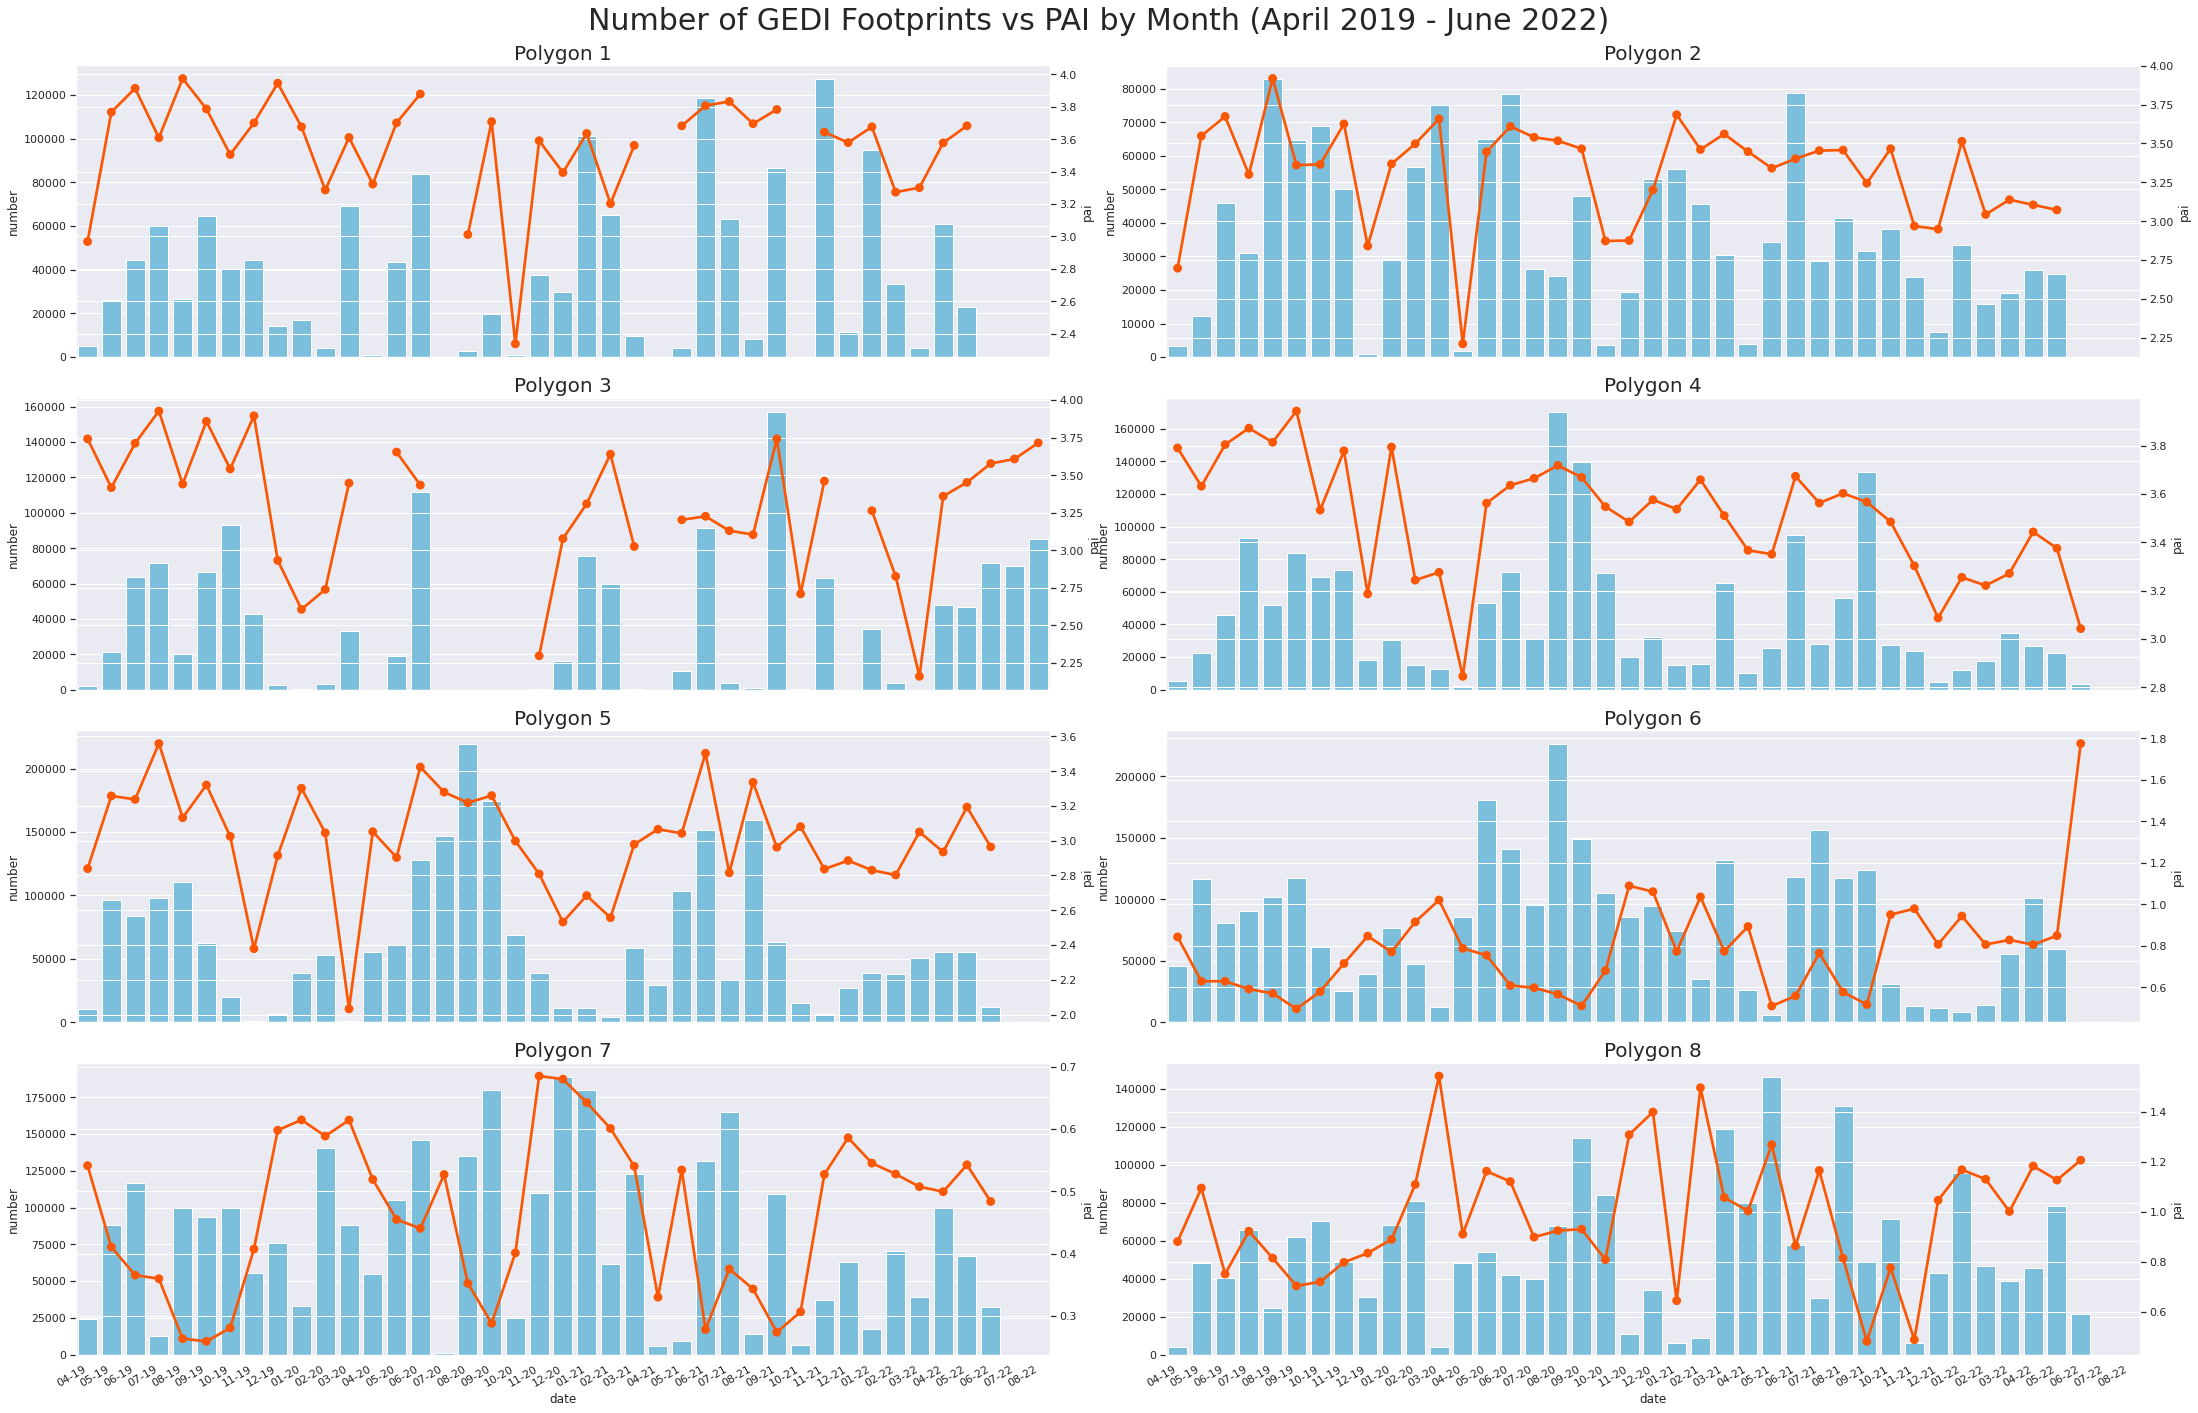

In [54]:
monthly_raw = get_gedi_monthly_for_plotting(footprints, start_date='04-2019', end_date='09-2022')
fig, ax = plot.layered_plot_per_polygon(monthly_raw, 
                                        x='date',
                                        bar_y='number',
                                        line_y='pai',
                                        title="Number of GEDI Footprints vs PAI by Month (April 2019 - June 2022)") # noqa: E501

fig.autofmt_xdate()

### Filter for Land Use

In [175]:
footprints_landuse = luf.land_use_filter(footprints, 3)

In [176]:
monthly_landuse = get_gedi_monthly_for_plotting(footprints_landuse, start_date='04-2019', end_date='09-2022')

['year', 'month', 'polygon_id']


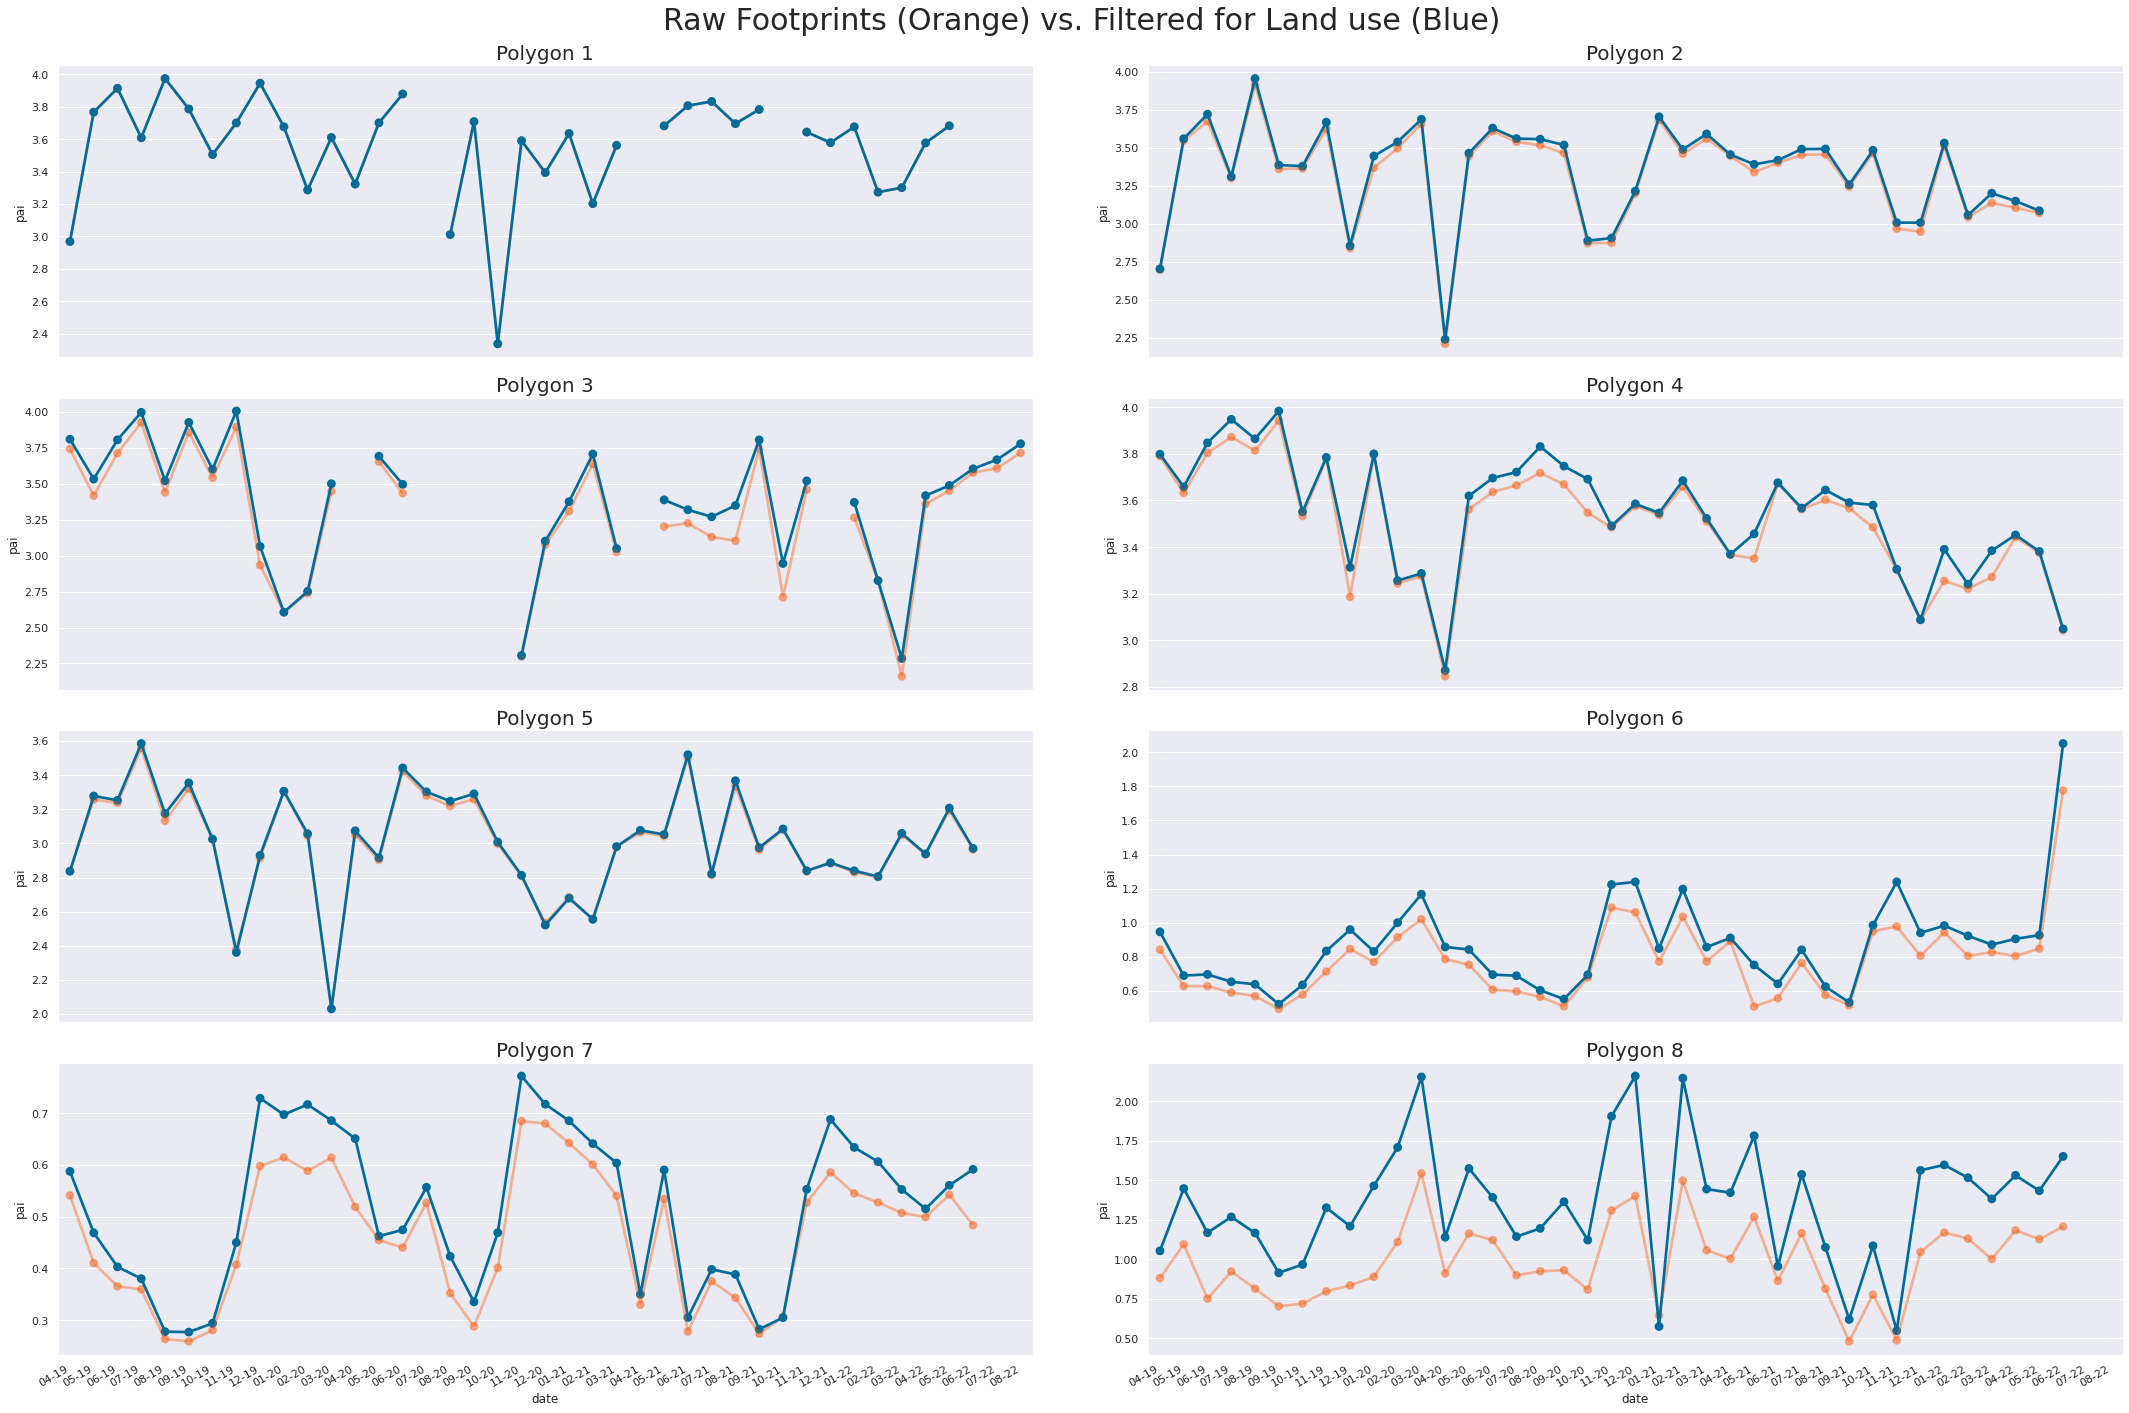

In [177]:
original_vs_filtered(monthly_raw, monthly_landuse, x='date', y='pai', title="Raw Footprints (Orange) vs. Filtered for Land use (Blue)")

In [178]:
footprints_landuse.to_csv("/maps-priv/maps/drought-with-gedi/gedi_data/gedi_footprints_extended_with_landuse_filtering.csv")

### Get fullbeam only footprints

In [55]:
footprints_fullbeam = footprints[footprints.beam_type == 'full']
footprints_fullbeam

geometry       pai   rh100  \
90      POINT (-73.01217550938594 -2.148433601199582)  3.270860  1547.0   
92      POINT (-73.01158014712219 -2.147592765811703)  0.226100   505.0   
104     POINT (-73.02228628616268 -2.162794720210879)  0.796234   771.0   
111     POINT (-72.7541482465911 -1.1639923700881025)  1.732929  1515.0   
112    POINT (-72.75474328953197 -1.1648345603875192)  1.270815   955.0   
...                                               ...       ...     ...   
90657  POINT (-61.85349658274967 -2.9219899085307888)  0.077517   544.0   
90658    POINT (-61.85320285940902 -2.92157475465289)  4.031361  2601.0   
90659  POINT (-61.852308928903625 -2.920311359981523)  3.155348  2175.0   
90660  POINT (-61.854544872890955 -2.933364965267634)  2.351011  3048.0   
90661   POINT (-61.85364969148409 -2.932099833952241)  1.774492  2006.0   

      beam_type  sensitivity  solar_elevation     cover  lon_lowestmode  \
90         full     0.937587       -28.760200  0.805052      -73.012176   
92         full     0.917372       -28.759361  0.106893      -73.011580   
104        full     0.941669       -28.774448  0.328407      -73.022286   
111        full     0.937474       -65.214005  0.579509      -72.754148   
112        full     0.919261       -65.215030  0.470246      -72.754743   
...         ...          ...              ...       ...             ...   
90657      full     0.981167        -8.832206  0.038015      -61.853497   
90658      full     0.990670        -8.831778  0.865177      -61.853203   
90659      full     0.978758        -8.830508  0.792299      -61.852309   
90660      full     0.983650        -8.836766  0.690480      -61.854545   
90661      full     0.963476        -8.835499  0.587630      -61.853650   

       lat_lowestmode  l2b_quality_flag    year  month  polygon_id  
90          -2.148434               1.0  2019.0    4.0         1.0  
92          -2.147593               1.0  2019.0    4.0         1.0  
104         -2.162795               1.0  2019.0    4.0         1.0  
111         -1.163992               1.0  2019.0    4.0         1.0  
112         -1.164835               1.0  2019.0    4.0         1.0  
...               ...               ...     ...    ...         ...  
90657       -2.921990               1.0  2022.0    8.0         3.0  
90658       -2.921575               1.0  2022.0    8.0         3.0  
90659       -2.920311               1.0  2022.0    8.0         3.0  
90660       -2.933365               1.0  2022.0    8.0         3.0  
90661       -2.932100               1.0  2022.0    8.0         3.0  

[9042467 rows x 13 columns]

In [58]:
monthly_fullbeam = get_gedi_monthly_for_plotting(footprints_fullbeam, start_date='04-2019', end_date='09-2022')

['year', 'month', 'polygon_id']


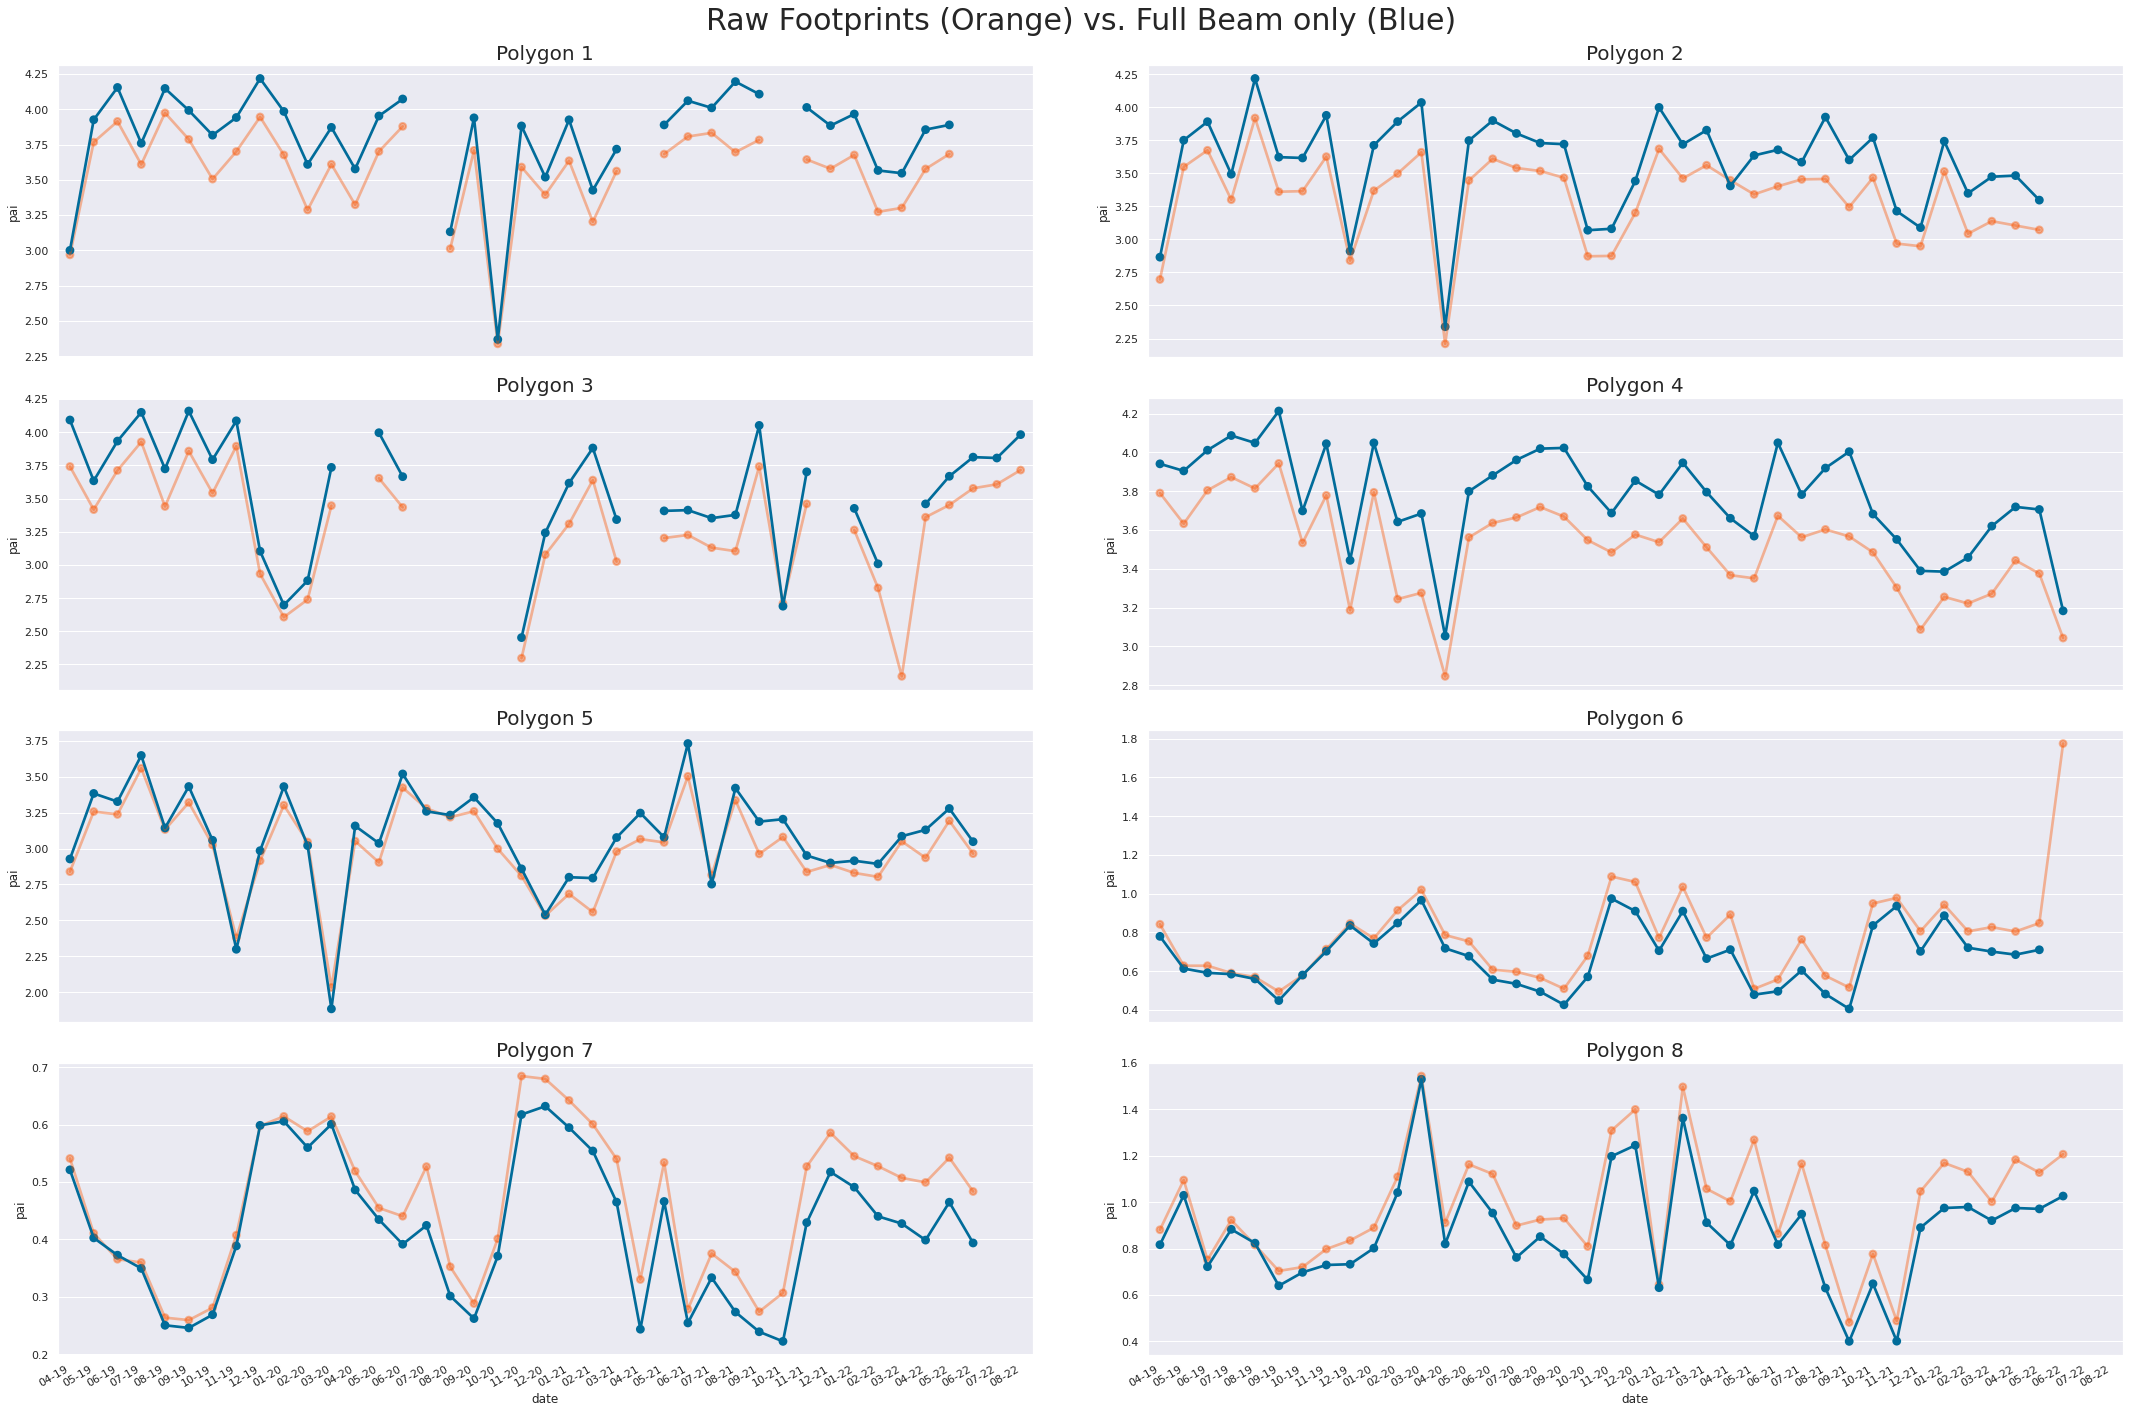

In [91]:
original_vs_filtered(monthly_raw, monthly_fullbeam, x='date', y='pai', title="Raw Footprints (Orange) vs. Full Beam only (Blue)")

### Get sensitivity > .95 only footprints

In [60]:
footprints_sensitivity = footprints[footprints.sensitivity >= 0.95]
footprints_sensitivity

geometry       pai   rh100  \
119     POINT (-72.7612806057573 -1.1644428765933692)  1.965926  1647.0   
162     POINT (-72.7544380531225 -1.1839217848355685)  3.246344  2153.0   
165    POINT (-72.75533086793847 -1.1851870967216789)  0.709193  1347.0   
170    POINT (-72.75830883551814 -1.1894094862946298)  2.685417  1272.0   
186    POINT (-72.75805771896245 -1.1794894895804888)  2.910288  1489.0   
...                                               ...       ...     ...   
90657  POINT (-61.85349658274967 -2.9219899085307888)  0.077517   544.0   
90658    POINT (-61.85320285940902 -2.92157475465289)  4.031361  2601.0   
90659  POINT (-61.852308928903625 -2.920311359981523)  3.155348  2175.0   
90660  POINT (-61.854544872890955 -2.933364965267634)  2.351011  3048.0   
90661   POINT (-61.85364969148409 -2.932099833952241)  1.774492  2006.0   

      beam_type  sensitivity  solar_elevation     cover  lon_lowestmode  \
119        full     0.952695       -65.220245  0.625732      -72.761281   
162        full     0.959454       -65.225365  0.802661      -72.754438   
165        full     0.963626       -65.226900  0.298537      -72.755331   
170        full     0.958475       -65.232020  0.738809      -72.758309   
186        full     0.957265       -65.225610  0.766575      -72.758058   
...         ...          ...              ...       ...             ...   
90657      full     0.981167        -8.832206  0.038015      -61.853497   
90658      full     0.990670        -8.831778  0.865177      -61.853203   
90659      full     0.978758        -8.830508  0.792299      -61.852309   
90660      full     0.983650        -8.836766  0.690480      -61.854545   
90661      full     0.963476        -8.835499  0.587630      -61.853650   

       lat_lowestmode  l2b_quality_flag    year  month  polygon_id  
119         -1.164443               1.0  2019.0    4.0         1.0  
162         -1.183922               1.0  2019.0    4.0         1.0  
165         -1.185187               1.0  2019.0    4.0         1.0  
170         -1.189409               1.0  2019.0    4.0         1.0  
186         -1.179489               1.0  2019.0    4.0         1.0  
...               ...               ...     ...    ...         ...  
90657       -2.921990               1.0  2022.0    8.0         3.0  
90658       -2.921575               1.0  2022.0    8.0         3.0  
90659       -2.920311               1.0  2022.0    8.0         3.0  
90660       -2.933365               1.0  2022.0    8.0         3.0  
90661       -2.932100               1.0  2022.0    8.0         3.0  

[13214137 rows x 13 columns]

In [61]:
monthly_sensitivity = get_gedi_monthly_for_plotting(footprints_sensitivity, start_date='04-2019', end_date='09-2022')

['year', 'month', 'polygon_id']


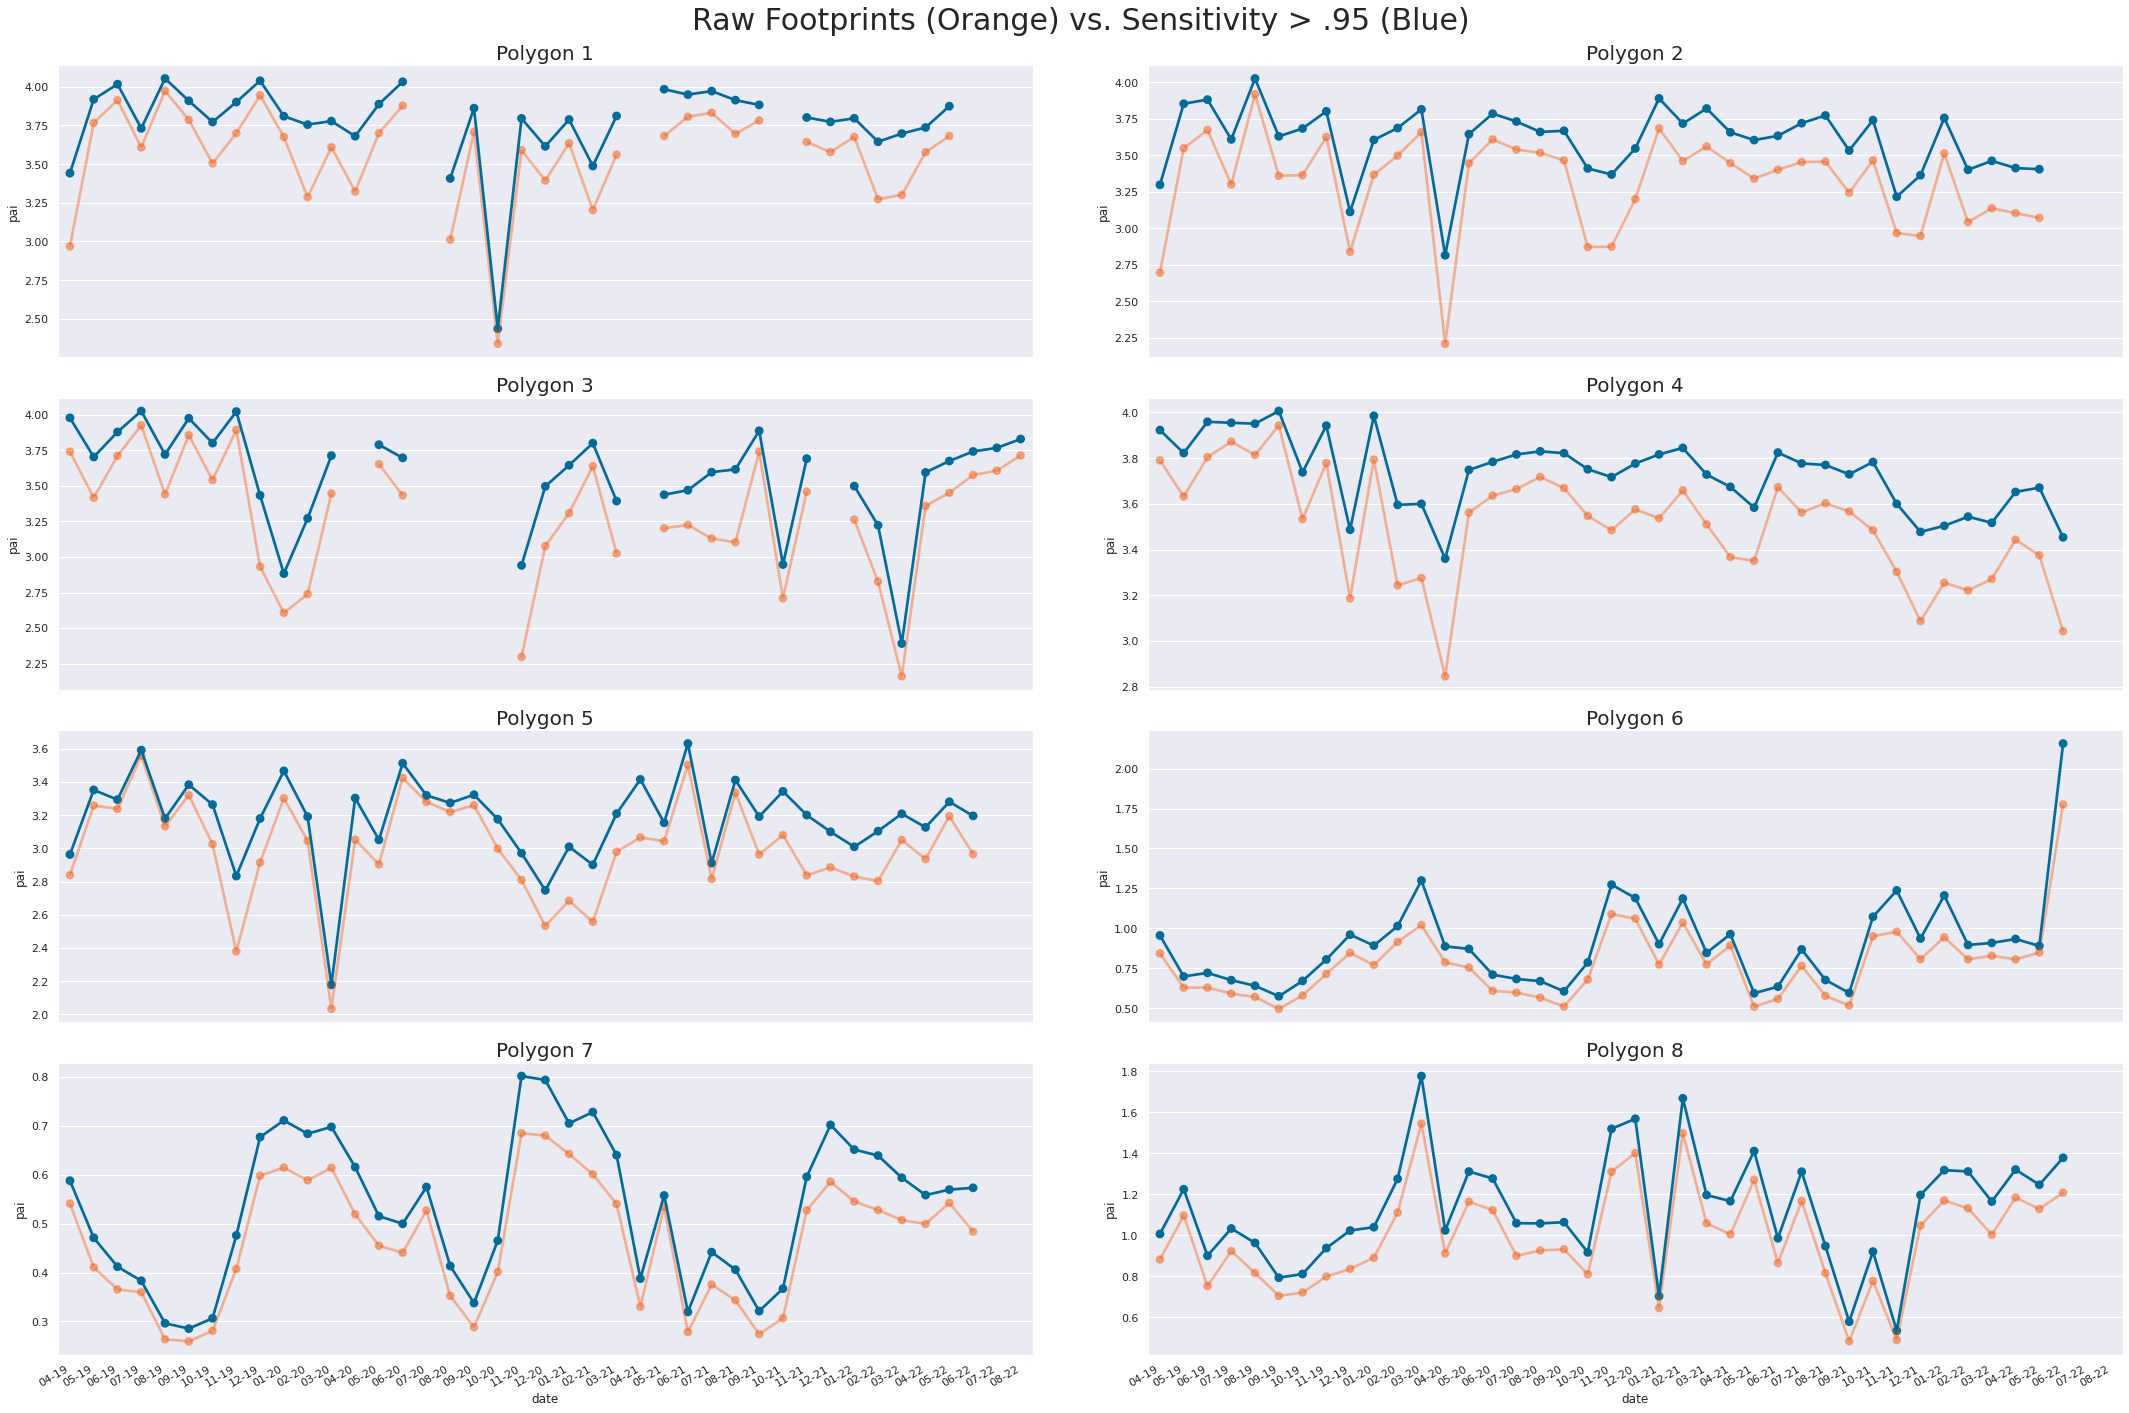

In [93]:
original_vs_filtered(monthly_raw, monthly_sensitivity, x='date', y='pai', title="Raw Footprints (Orange) vs. Sensitivity > .95 (Blue)")

### Cover > .3 and Height > 5m

In [65]:
footprints_forest = footprints[(footprints.cover >= 0.3) & (footprints.rh100 > 500)]
footprints_forest

geometry       pai   rh100  \
90      POINT (-73.01217550938594 -2.148433601199582)  3.270860  1547.0   
104     POINT (-73.02228628616268 -2.162794720210879)  0.796234   771.0   
111     POINT (-72.7541482465911 -1.1639923700881025)  1.732929  1515.0   
112    POINT (-72.75474328953197 -1.1648345603875192)  1.270815   955.0   
113    POINT (-72.75504141918285 -1.1652581962816098)  1.625259   882.0   
...                                               ...       ...     ...   
90656  POINT (-61.85379895186377 -2.9224171505468637)  2.286948  2025.0   
90658    POINT (-61.85320285940902 -2.92157475465289)  4.031361  2601.0   
90659  POINT (-61.852308928903625 -2.920311359981523)  3.155348  2175.0   
90660  POINT (-61.854544872890955 -2.933364965267634)  2.351011  3048.0   
90661   POINT (-61.85364969148409 -2.932099833952241)  1.774492  2006.0   

      beam_type  sensitivity  solar_elevation     cover  lon_lowestmode  \
90         full     0.937587       -28.760200  0.805052      -73.012176   
104        full     0.941669       -28.774448  0.328407      -73.022286   
111        full     0.937474       -65.214005  0.579509      -72.754148   
112        full     0.919261       -65.215030  0.470246      -72.754743   
113        full     0.913839       -65.215540  0.556259      -72.755041   
...         ...          ...              ...       ...             ...   
90656      full     0.962868        -8.832627  0.680446      -61.853799   
90658      full     0.990670        -8.831778  0.865177      -61.853203   
90659      full     0.978758        -8.830508  0.792299      -61.852309   
90660      full     0.983650        -8.836766  0.690480      -61.854545   
90661      full     0.963476        -8.835499  0.587630      -61.853650   

       lat_lowestmode  l2b_quality_flag    year  month  polygon_id  
90          -2.148434               1.0  2019.0    4.0         1.0  
104         -2.162795               1.0  2019.0    4.0         1.0  
111         -1.163992               1.0  2019.0    4.0         1.0  
112         -1.164835               1.0  2019.0    4.0         1.0  
113         -1.165258               1.0  2019.0    4.0         1.0  
...               ...               ...     ...    ...         ...  
90656       -2.922417               1.0  2022.0    8.0         3.0  
90658       -2.921575               1.0  2022.0    8.0         3.0  
90659       -2.920311               1.0  2022.0    8.0         3.0  
90660       -2.933365               1.0  2022.0    8.0         3.0  
90661       -2.932100               1.0  2022.0    8.0         3.0  

[9716417 rows x 13 columns]

In [66]:
monthly_forest = get_gedi_monthly_for_plotting(footprints_forest, start_date='04-2019', end_date='09-2022')

['year', 'month', 'polygon_id']


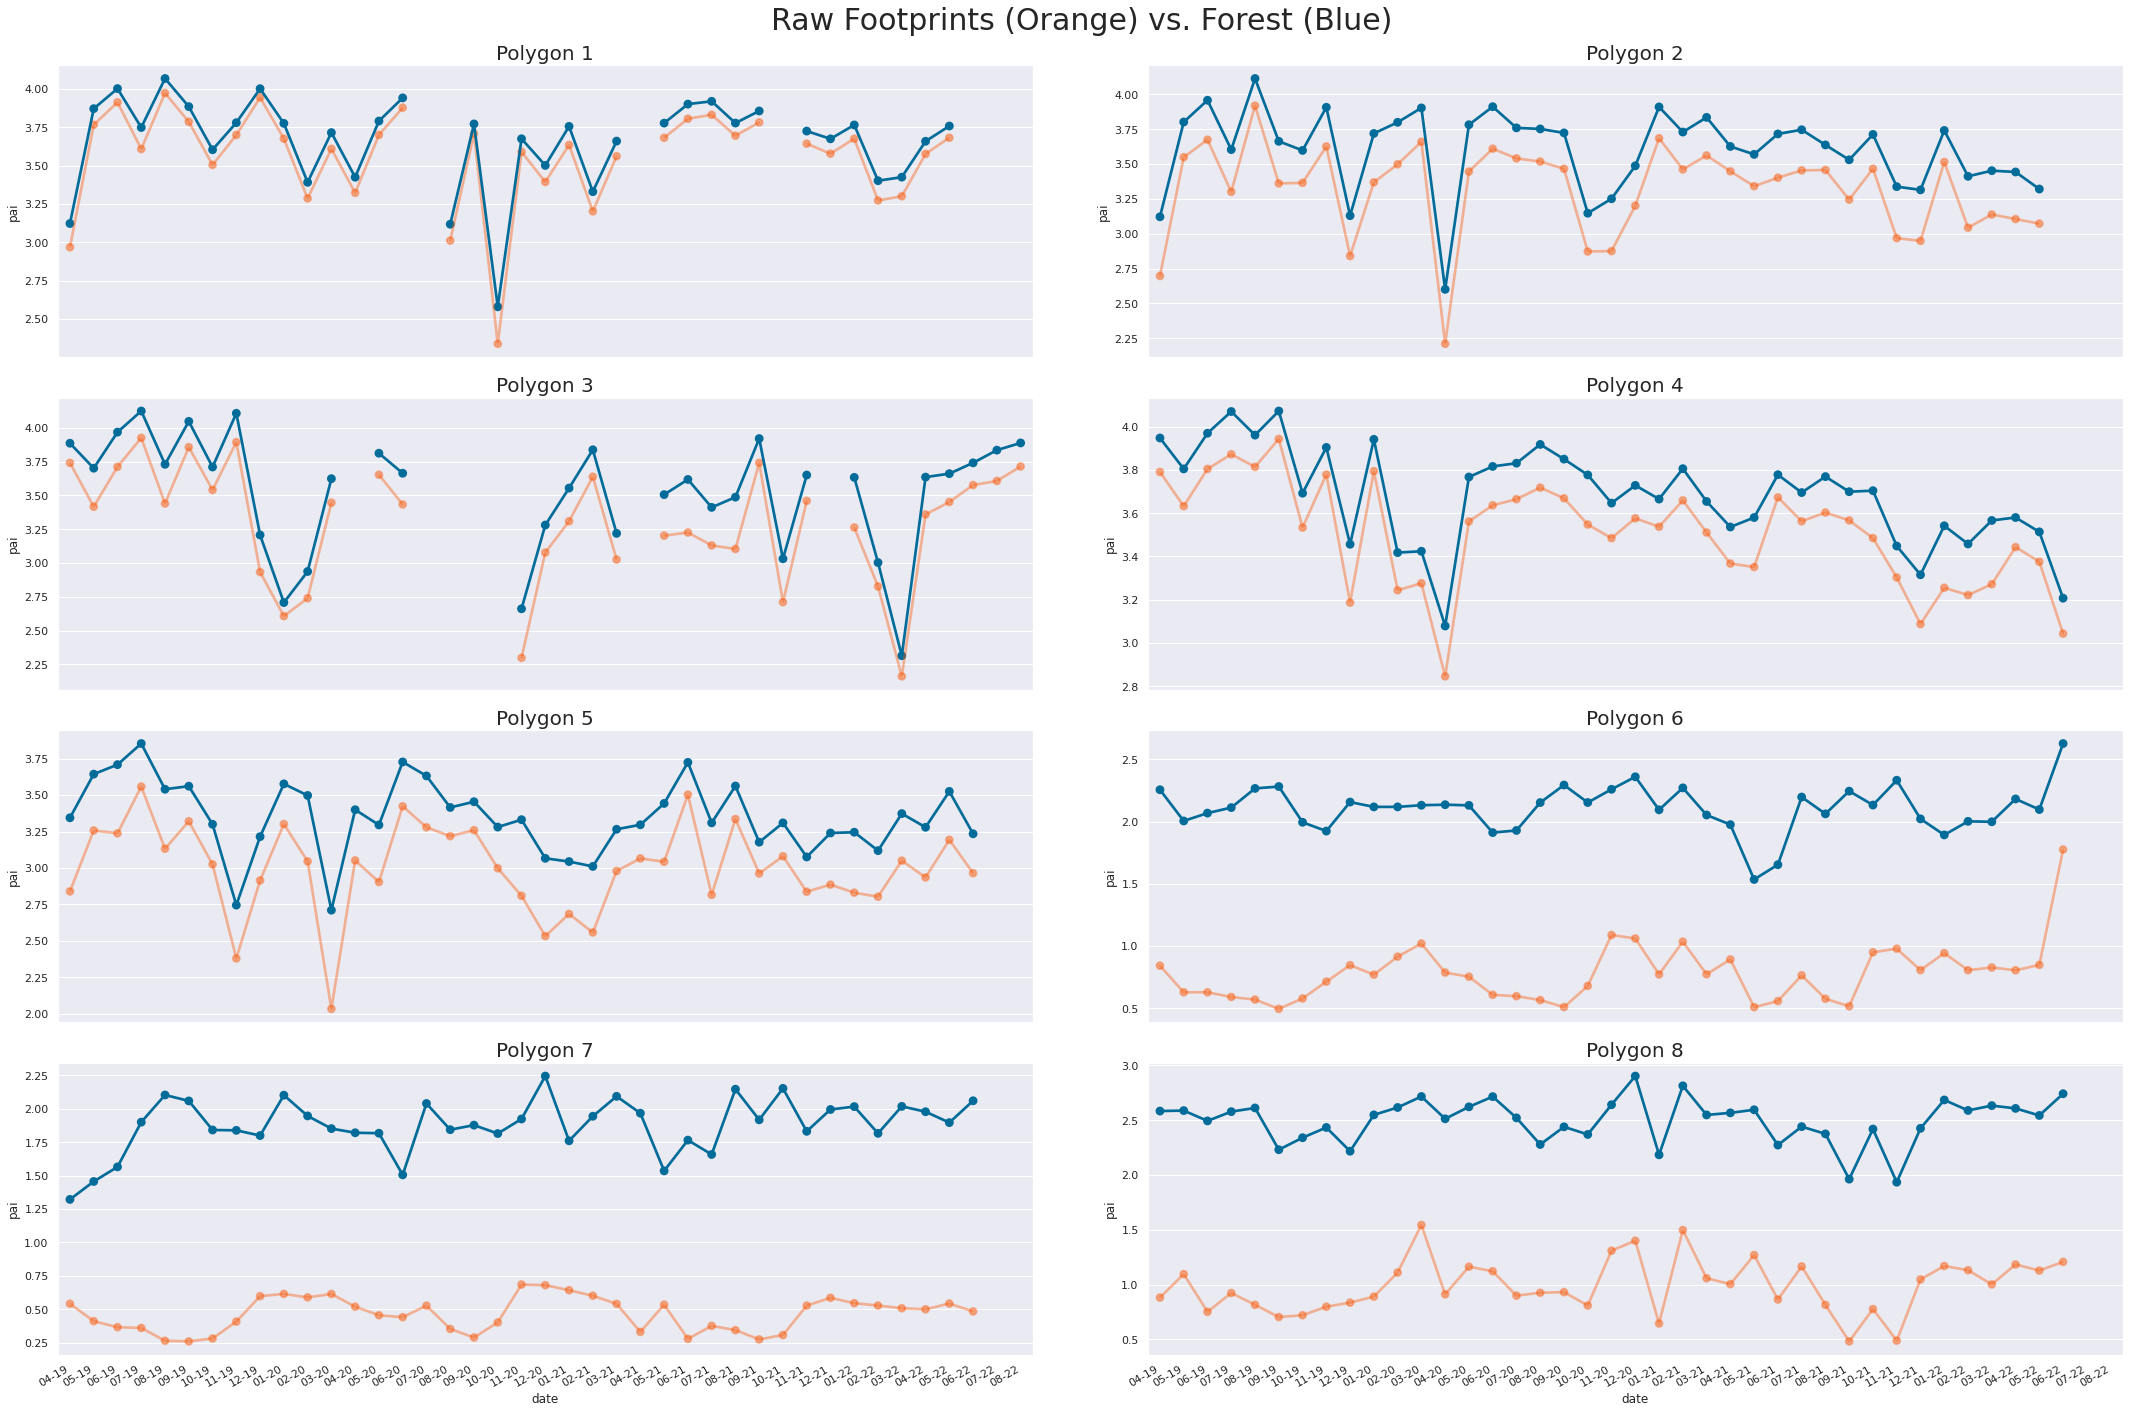

In [94]:
original_vs_filtered(monthly_raw, monthly_forest, x='date', y='pai', title="Raw Footprints (Orange) vs. Forest (Blue)")

### Negative Solar Elevation

In [69]:
footprints_night = footprints[footprints.solar_elevation < 0]
footprints_night

geometry       pai   rh100  \
90      POINT (-73.01217550938594 -2.148433601199582)  3.270860  1547.0   
92      POINT (-73.01158014712219 -2.147592765811703)  0.226100   505.0   
104     POINT (-73.02228628616268 -2.162794720210879)  0.796234   771.0   
111     POINT (-72.7541482465911 -1.1639923700881025)  1.732929  1515.0   
112    POINT (-72.75474328953197 -1.1648345603875192)  1.270815   955.0   
...                                               ...       ...     ...   
90657  POINT (-61.85349658274967 -2.9219899085307888)  0.077517   544.0   
90658    POINT (-61.85320285940902 -2.92157475465289)  4.031361  2601.0   
90659  POINT (-61.852308928903625 -2.920311359981523)  3.155348  2175.0   
90660  POINT (-61.854544872890955 -2.933364965267634)  2.351011  3048.0   
90661   POINT (-61.85364969148409 -2.932099833952241)  1.774492  2006.0   

      beam_type  sensitivity  solar_elevation     cover  lon_lowestmode  \
90         full     0.937587       -28.760200  0.805052      -73.012176   
92         full     0.917372       -28.759361  0.106893      -73.011580   
104        full     0.941669       -28.774448  0.328407      -73.022286   
111        full     0.937474       -65.214005  0.579509      -72.754148   
112        full     0.919261       -65.215030  0.470246      -72.754743   
...         ...          ...              ...       ...             ...   
90657      full     0.981167        -8.832206  0.038015      -61.853497   
90658      full     0.990670        -8.831778  0.865177      -61.853203   
90659      full     0.978758        -8.830508  0.792299      -61.852309   
90660      full     0.983650        -8.836766  0.690480      -61.854545   
90661      full     0.963476        -8.835499  0.587630      -61.853650   

       lat_lowestmode  l2b_quality_flag    year  month  polygon_id  
90          -2.148434               1.0  2019.0    4.0         1.0  
92          -2.147593               1.0  2019.0    4.0         1.0  
104         -2.162795               1.0  2019.0    4.0         1.0  
111         -1.163992               1.0  2019.0    4.0         1.0  
112         -1.164835               1.0  2019.0    4.0         1.0  
...               ...               ...     ...    ...         ...  
90657       -2.921990               1.0  2022.0    8.0         3.0  
90658       -2.921575               1.0  2022.0    8.0         3.0  
90659       -2.920311               1.0  2022.0    8.0         3.0  
90660       -2.933365               1.0  2022.0    8.0         3.0  
90661       -2.932100               1.0  2022.0    8.0         3.0  

[8515415 rows x 13 columns]

In [70]:
monthly_night = get_gedi_monthly_for_plotting(footprints_night, start_date='04-2019', end_date='09-2022')

['year', 'month', 'polygon_id']


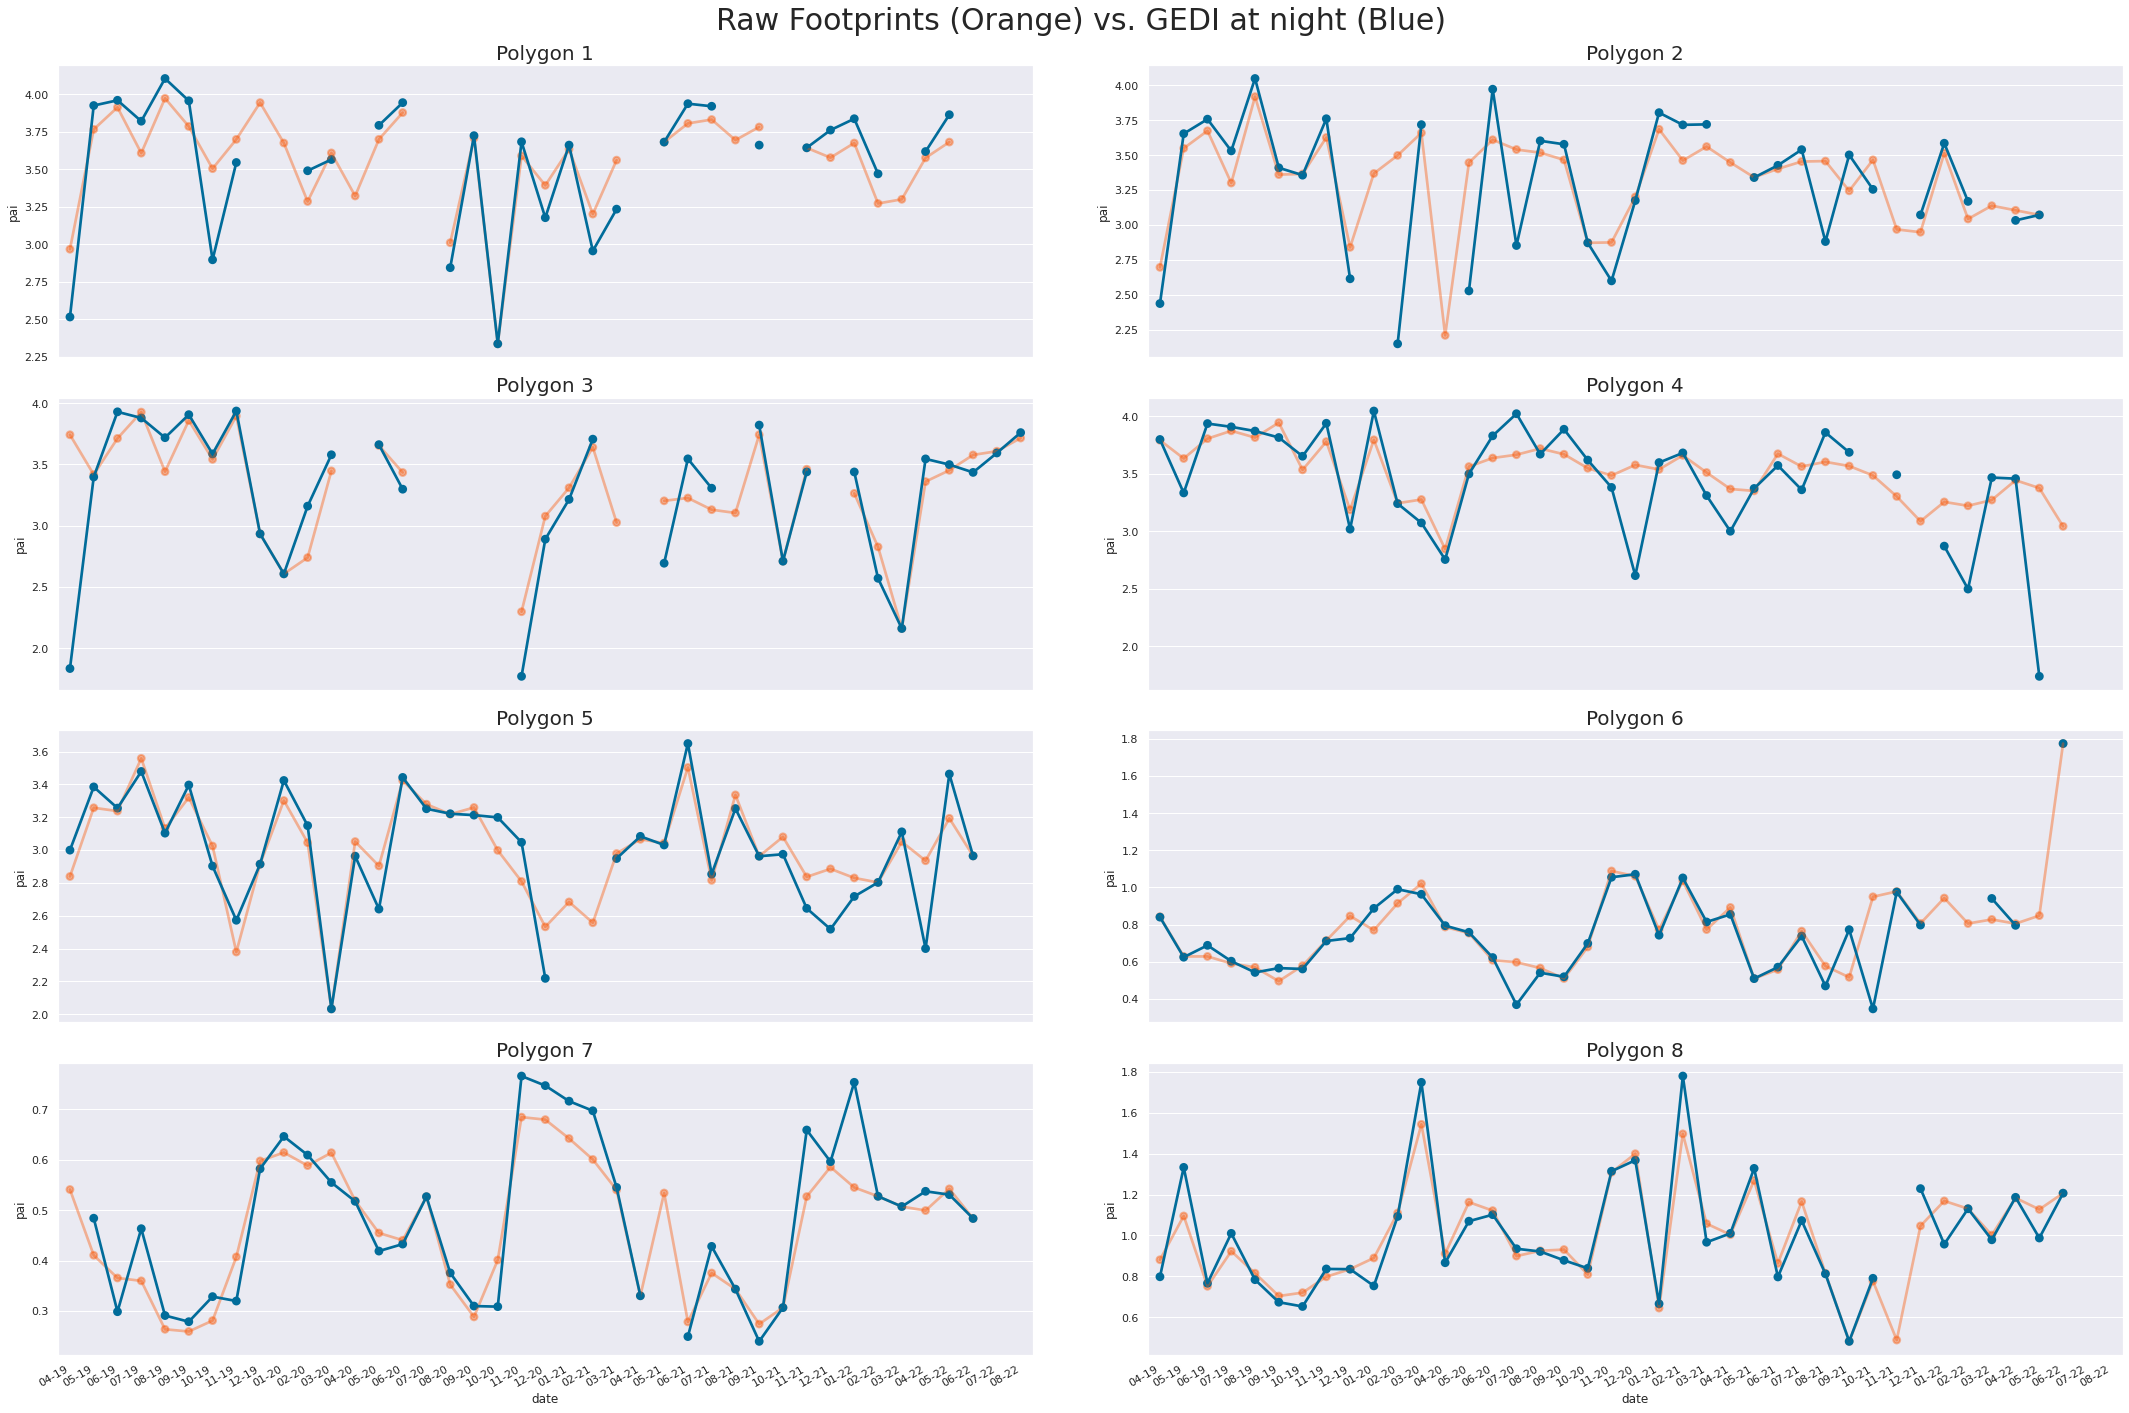

In [95]:
original_vs_filtered(monthly_raw, monthly_night, x='date', y='pai', title="Raw Footprints (Orange) vs. GEDI at night (Blue)")

### Combine fullbeam, forest, land use and sensitivity filters

In [179]:
# Apply filters only for polygons 1-5
footprints_filtered = footprints_landuse[(footprints_landuse.polygon_id > 5) | ((footprints_landuse.sensitivity >= .95) & (footprints_landuse.cover >= 0.3) & (footprints_landuse.rh100 > 500) & (footprints_landuse.beam_type == 'full'))]
footprints_filtered

geometry       pai   rh100  \
119     POINT (-72.7612806057573 -1.1644428765933692)  1.965926  1647.0   
162     POINT (-72.7544380531225 -1.1839217848355685)  3.246344  2153.0   
170    POINT (-72.75830883551814 -1.1894094862946298)  2.685417  1272.0   
186    POINT (-72.75805771896245 -1.1794894895804888)  2.910288  1489.0   
188    POINT (-72.75865297430727 -1.1803329966508127)  2.925634  1564.0   
...                                               ...       ...     ...   
90656  POINT (-61.85379895186377 -2.9224171505468637)  2.286948  2025.0   
90658    POINT (-61.85320285940902 -2.92157475465289)  4.031361  2601.0   
90659  POINT (-61.852308928903625 -2.920311359981523)  3.155348  2175.0   
90660  POINT (-61.854544872890955 -2.933364965267634)  2.351011  3048.0   
90661   POINT (-61.85364969148409 -2.932099833952241)  1.774492  2006.0   

      beam_type  sensitivity  solar_elevation     cover  lon_lowestmode  \
119        full     0.952695       -65.220245  0.625732      -72.761281   
162        full     0.959454       -65.225365  0.802661      -72.754438   
170        full     0.958475       -65.232020  0.738809      -72.758309   
186        full     0.957265       -65.225610  0.766575      -72.758058   
188        full     0.953703       -65.226630  0.768359      -72.758653   
...         ...          ...              ...       ...             ...   
90656      full     0.962868        -8.832627  0.680446      -61.853799   
90658      full     0.990670        -8.831778  0.865177      -61.853203   
90659      full     0.978758        -8.830508  0.792299      -61.852309   
90660      full     0.983650        -8.836766  0.690480      -61.854545   
90661      full     0.963476        -8.835499  0.587630      -61.853650   

       lat_lowestmode  l2b_quality_flag    year  month  polygon_id  
119         -1.164443               1.0  2019.0    4.0         1.0  
162         -1.183922               1.0  2019.0    4.0         1.0  
170         -1.189409               1.0  2019.0    4.0         1.0  
186         -1.179489               1.0  2019.0    4.0         1.0  
188         -1.180333               1.0  2019.0    4.0         1.0  
...               ...               ...     ...    ...         ...  
90656       -2.922417               1.0  2022.0    8.0         3.0  
90658       -2.921575               1.0  2022.0    8.0         3.0  
90659       -2.920311               1.0  2022.0    8.0         3.0  
90660       -2.933365               1.0  2022.0    8.0         3.0  
90661       -2.932100               1.0  2022.0    8.0         3.0  

[8239373 rows x 13 columns]

In [180]:
monthly_filtered = get_gedi_monthly_for_plotting(footprints_filtered, start_date='04-2019', end_date='09-2022')

['year', 'month', 'polygon_id']


In [181]:
monthly_filtered.drop(monthly_filtered[(monthly_filtered.polygon_id != 3) & (monthly_filtered.datetime > '2022-06-01')].index, inplace=True)

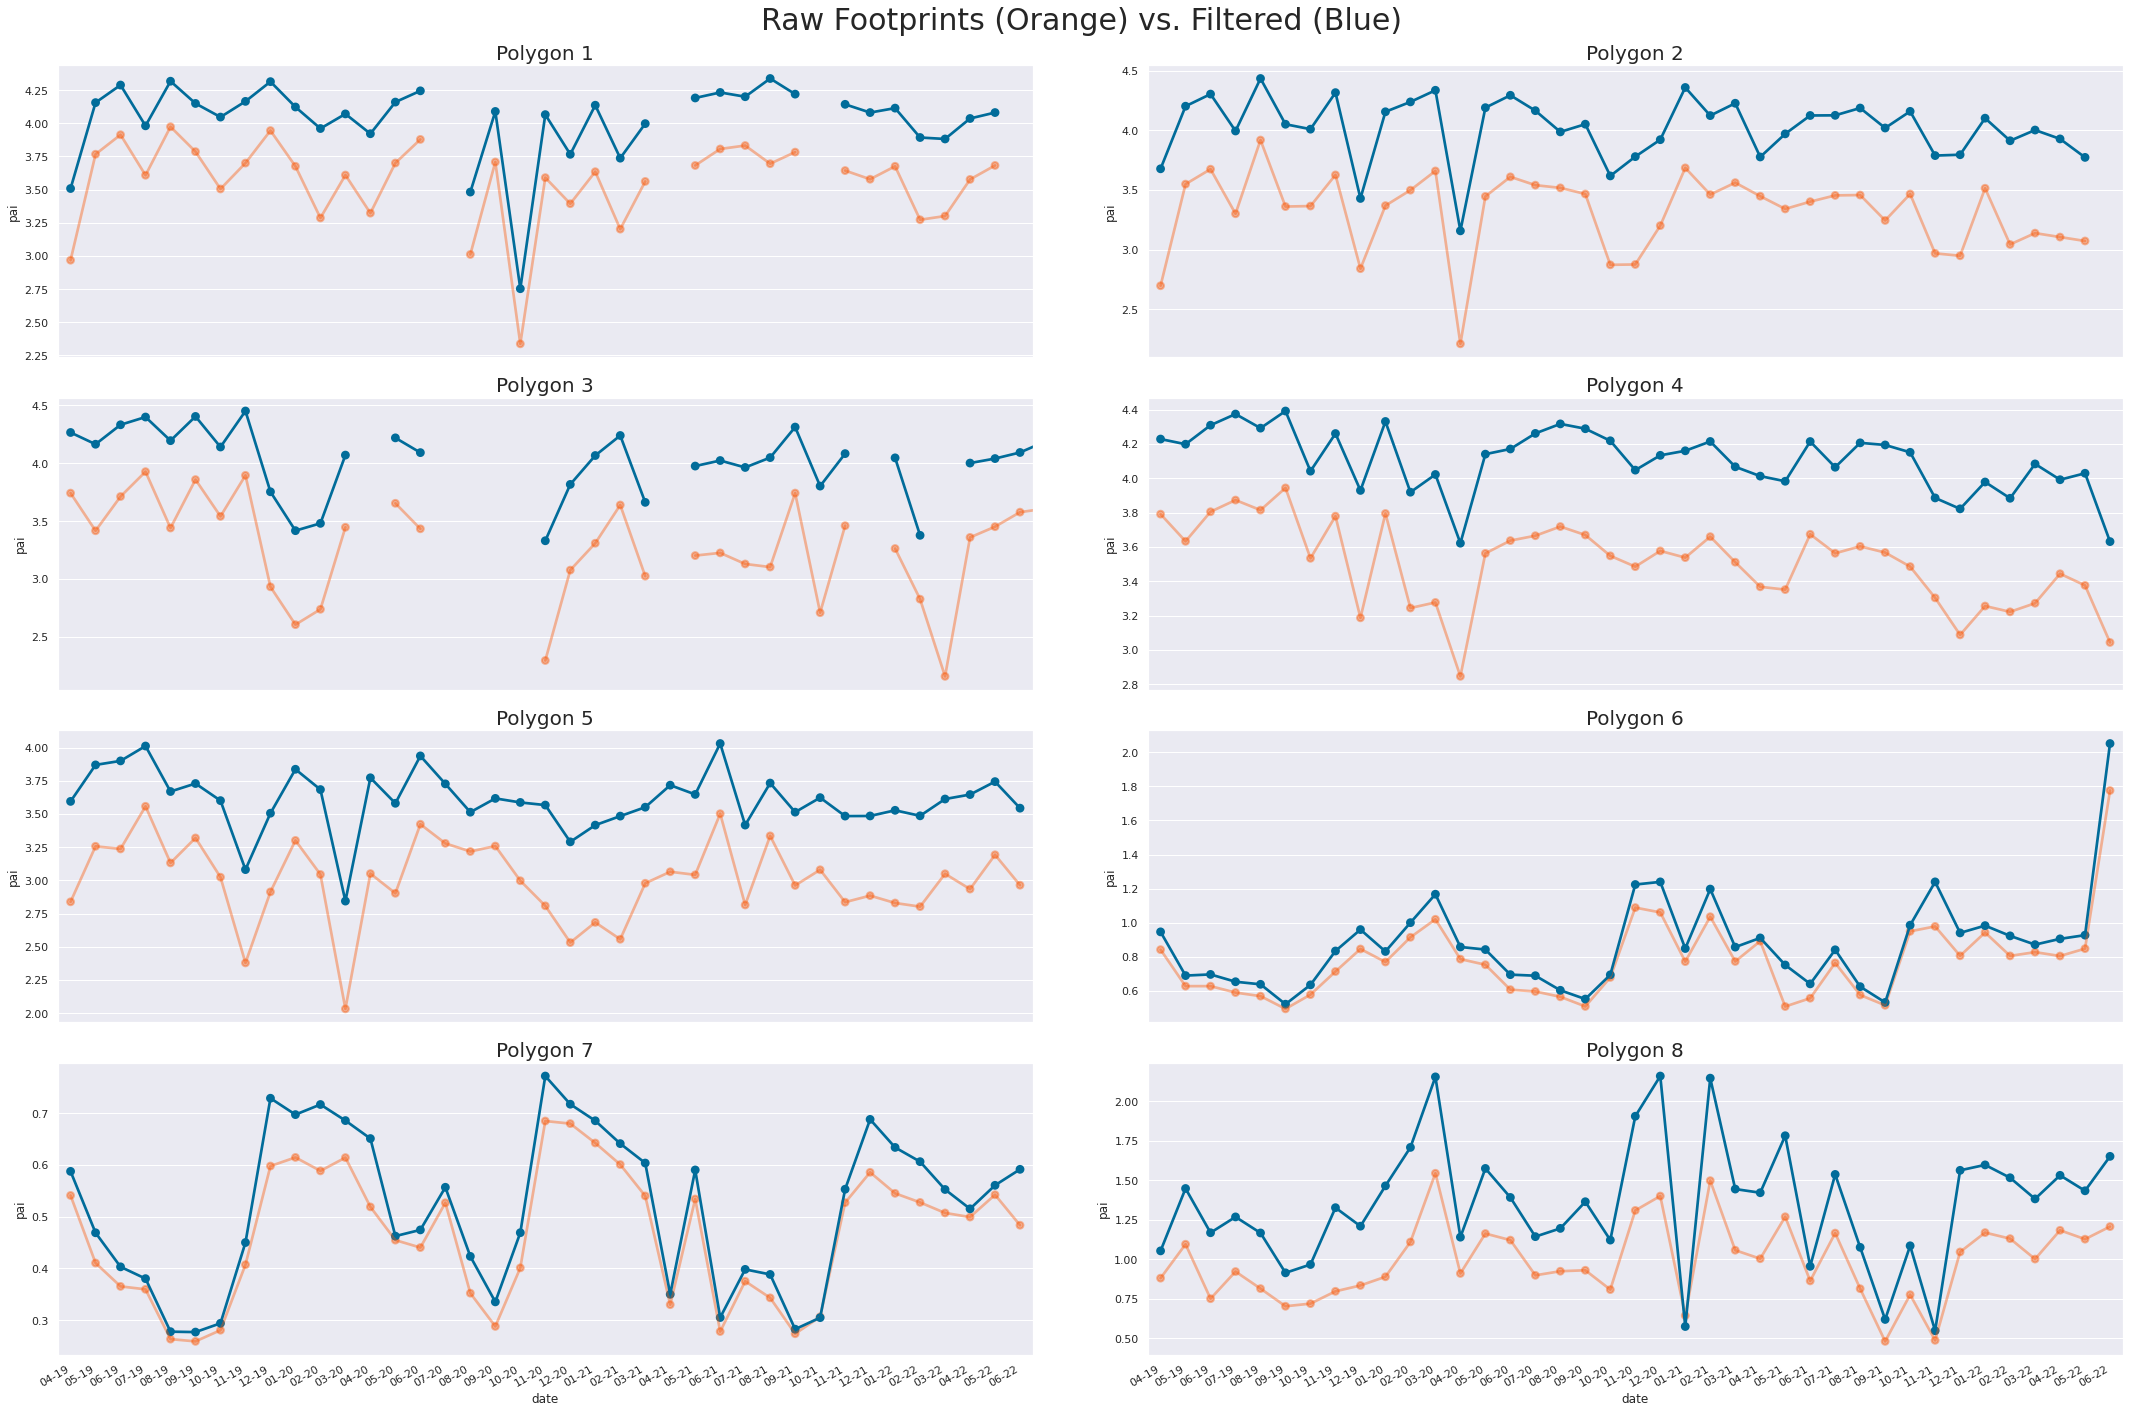

In [182]:
original_vs_filtered(monthly_raw, monthly_filtered, x='date', y='pai', title="Raw Footprints (Orange) vs. Filtered (Blue)")

In [183]:
footprints_filtered.to_csv("/maps-priv/maps/drought-with-gedi/gedi_data/gedi_extended_filtered.csv" )

## Interpolate data using weighted sliding window

We've observed that we have outlier data in the months where we've collected fewer number of GEDI shots.

Here we propose to interpolate the data to adjust the values for these outliers or months where we have missing data, relying on the data from adjacent months.

We make two assumptions:
1. There is a gradual PAI change from month to month, and we don't expect to see sudden large PAI changes in a single month. Specifically, we don't expect to see patterns of the kind low-high-low or high-low-high, where the middle month in the 3 month span is significantly different from the adjacent before and after months.
2. On average, months with more GEDI shots should yield more accurate PAI estimates than months with fewer GEDI shots.

We implement data interpolation based on these two assumptions in the following way:
* For each month, we take a look at the PAI value for the month and its two adjacent months - the month before and the month after. Let's call these previous, current, next.
* For each month, we keep track of two values: number of GEDI shots for that month, and PAI value. These are called 'number' and 'pai' respectively.
* Interpolated PAI value is then calculated in the following way:

  <font size="6">$pai_i = \frac{(pai_{i-1}\cdot number_{i-1} + pai_i\cdot number_i + pai_{i+1}\cdot number_{i+1})}{(number_{i-1} + number_i + number_{i+1})}$</font>

This interpolation method will do a weighted average for each 3 adjacent months, giving higher weight to months with more GEDI shots.

In [199]:
# Process data. Set missing pai values to zero, to avoid NaN sums.
monthly_interim = monthly_filtered.fillna(0)

In [200]:
monthly_after_weighted_average = interpolate.interpolate_using_weighted_average(monthly_interim, weight='number', value='pai')
monthly_after_weighted_average = interpolate.interpolate_using_weighted_average(monthly_after_weighted_average, weight='number', value='rh100')

In [201]:
monthly_after_weighted_average.pai = monthly_after_weighted_average.pai_interpolated
monthly_after_weighted_average.rh100 = monthly_after_weighted_average.rh100_interpolated
monthly_after_weighted_average = monthly_after_weighted_average.drop(columns=['pai_interpolated', 'rh100_interpolated'])

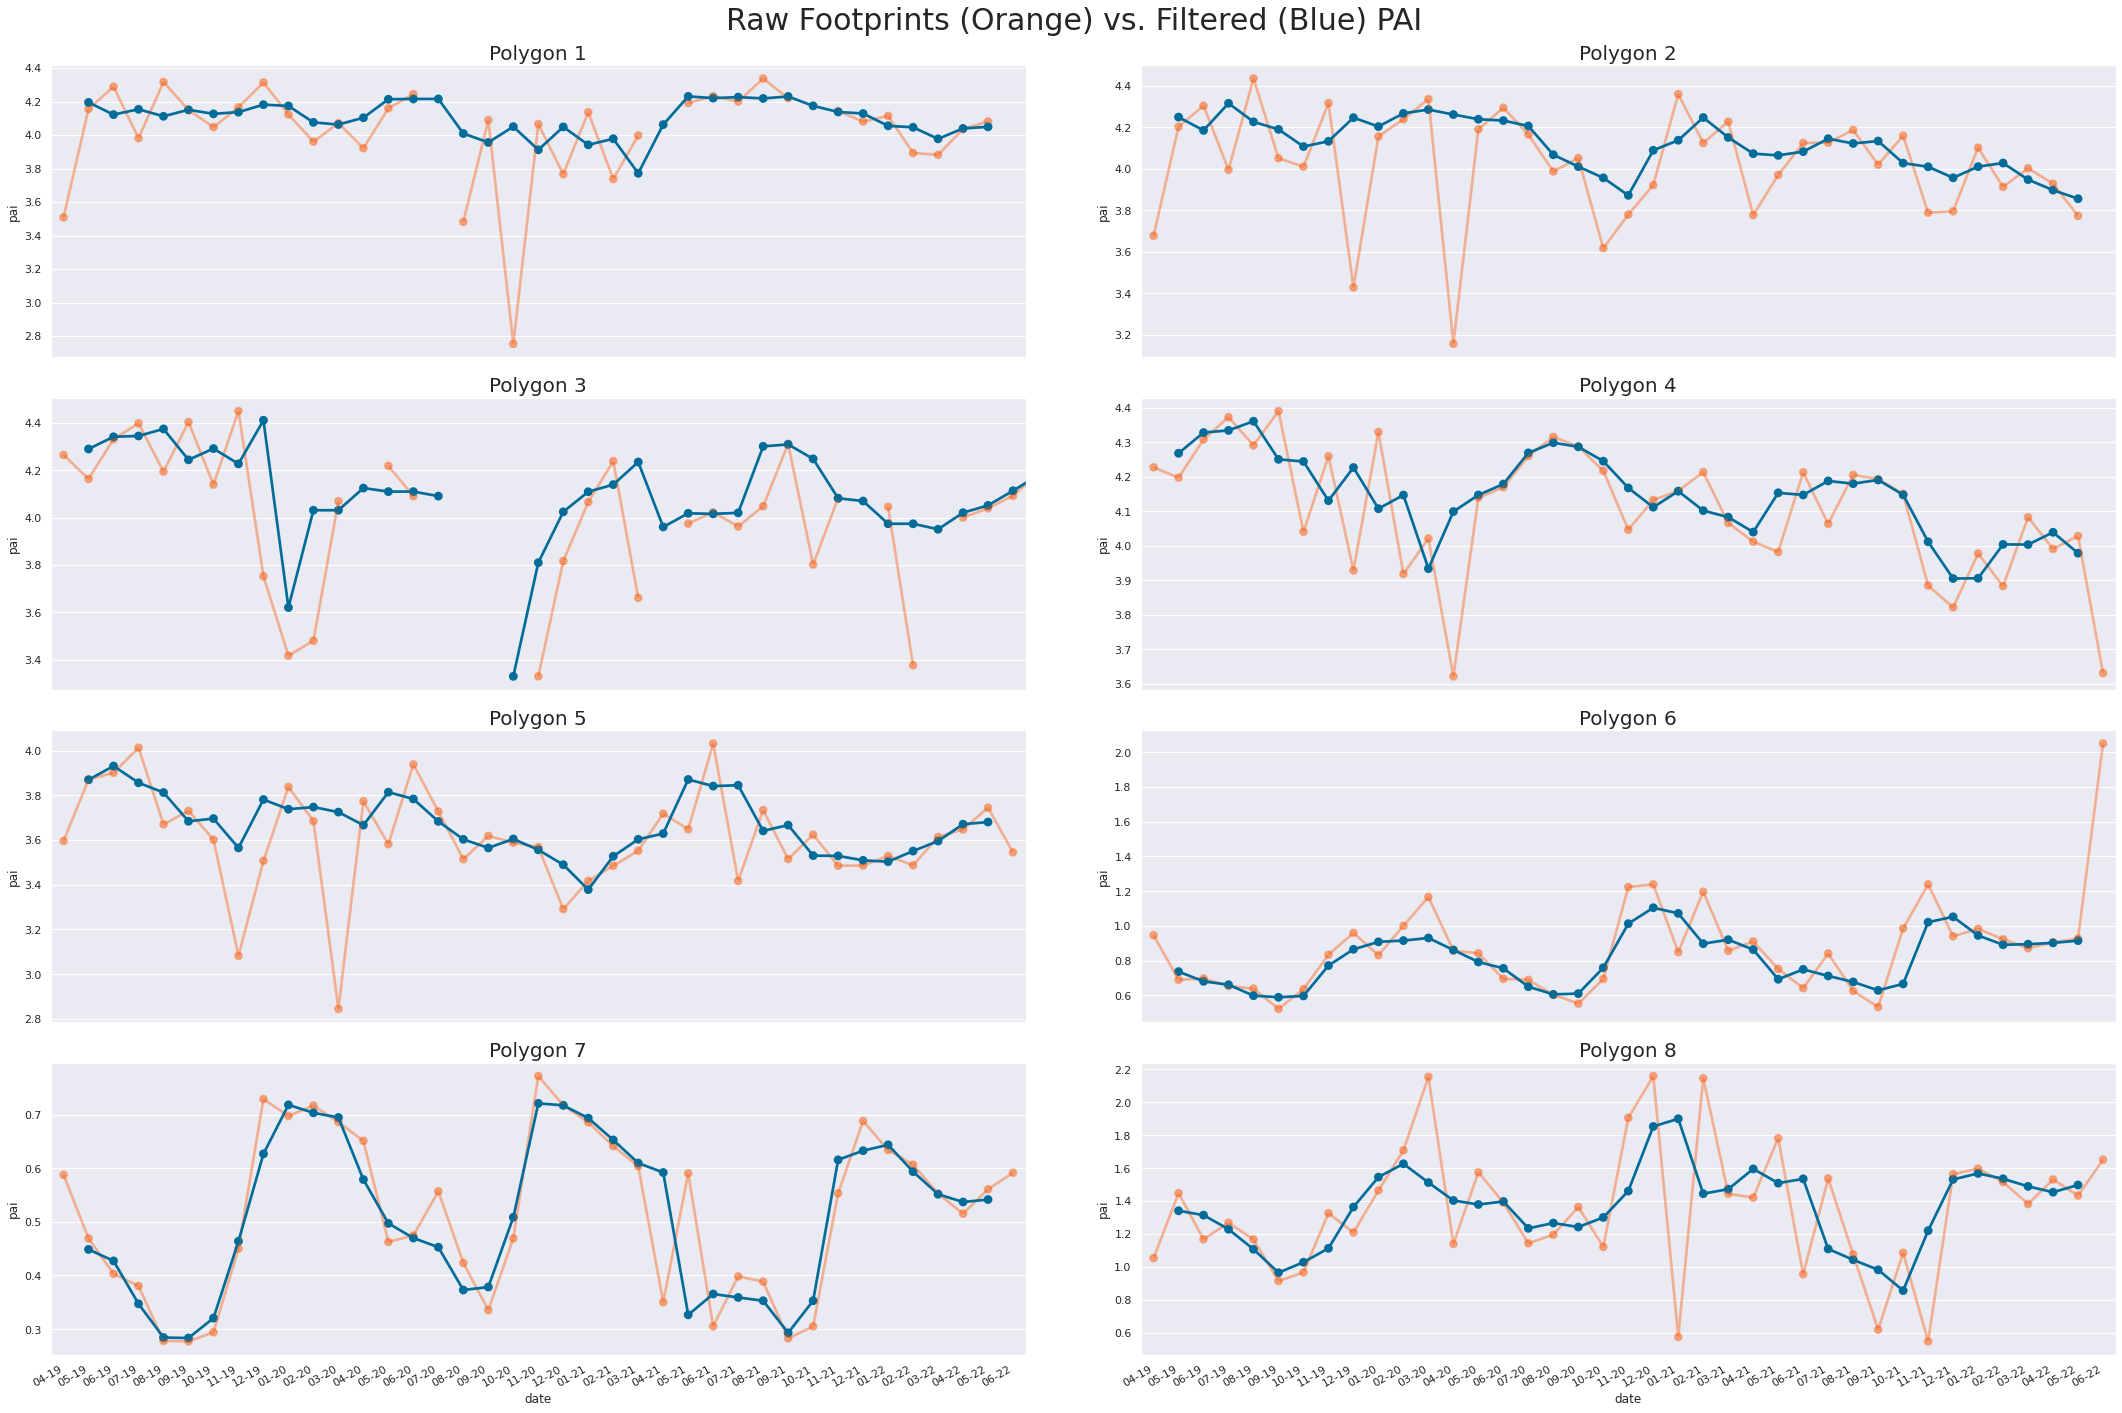

In [202]:
original_vs_filtered(monthly_filtered, monthly_after_weighted_average, x='date', y='pai', title="Raw Footprints (Orange) vs. Filtered (Blue) PAI")

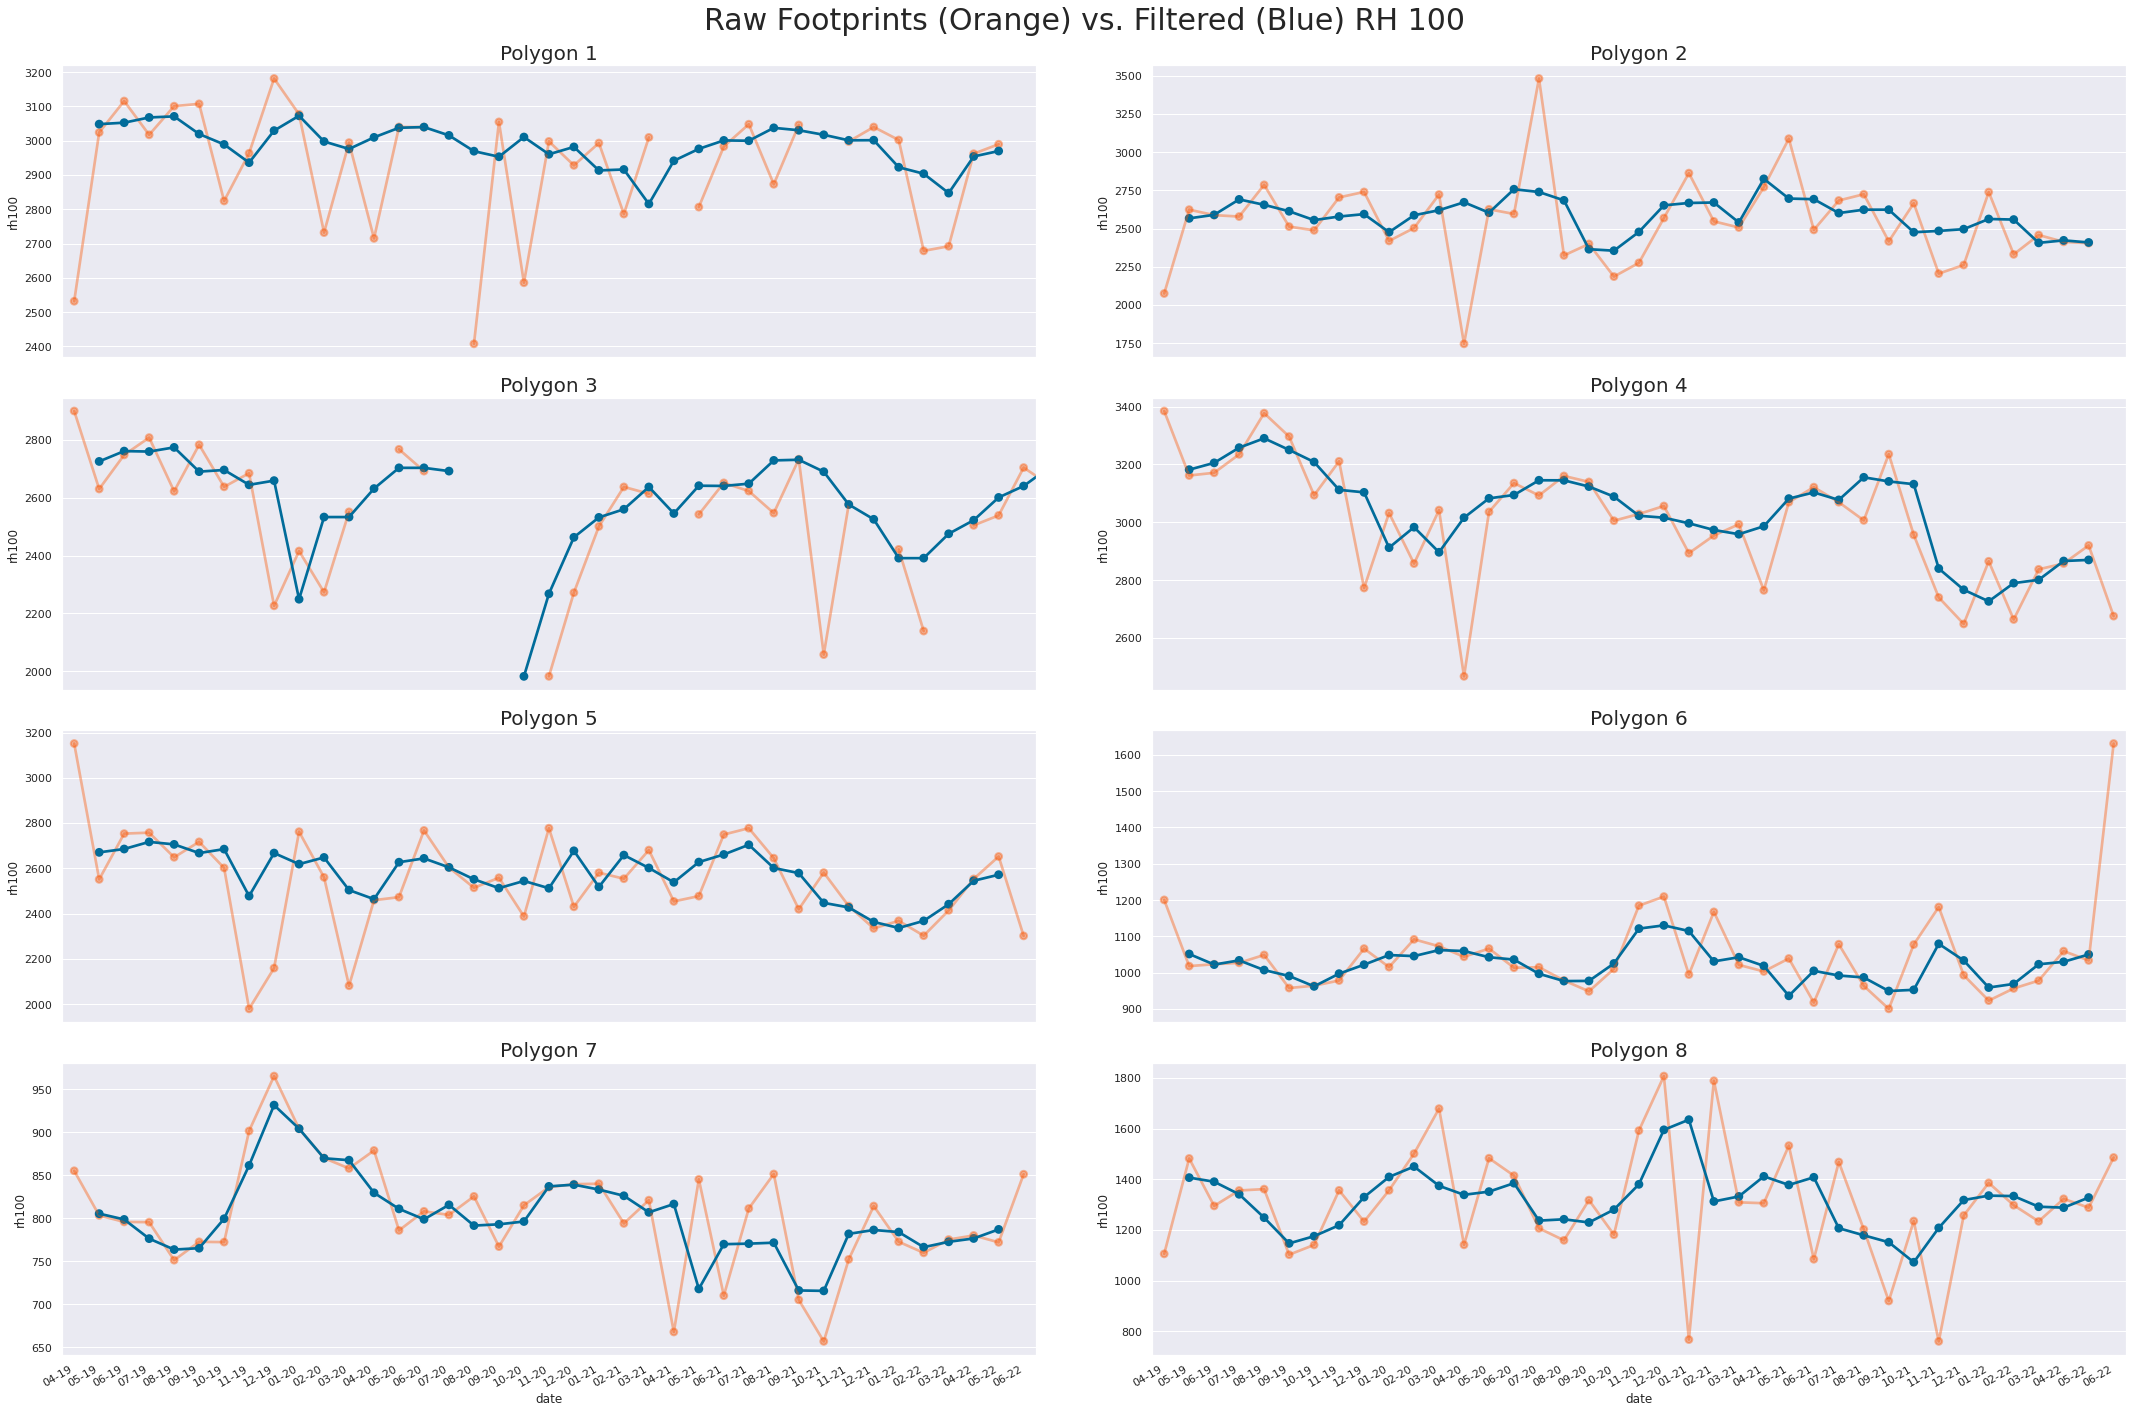

In [203]:
original_vs_filtered(monthly_filtered, monthly_after_weighted_average, x='date', y='rh100', title="Raw Footprints (Orange) vs. Filtered (Blue) RH 100")

In [204]:
monthly_after_weighted_average.to_csv("../../data/interim/gedi_monthly_extended_interpolated_March_11.csv")

### Analyze individual months

In [184]:
def plot_monthly_time_series(df, polygon_id):
    fig, ax = plt.subplots(2, 1, figsize=(25, 10))
    fig.suptitle(f'Polygon monthly mean timeseries {polygon_id}', fontsize=20)

    polygon_data = df.loc[(df.polygon_id == polygon_id)]
    
    sns.pointplot(polygon_data, x='date', y='rh100', ax=ax[1])

    #bar_ax = ax[0].twinx()
    sns.pointplot(polygon_data, x='date', y='pai', ax=ax[0], color='#FA5705')
    fig.autofmt_xdate()
    plt.show()


In [185]:
def plot_one_month_data(df, polygon_id, month, year, pai_x_lim_max=6, pai_threshold=0.1):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Footprints for polygon {polygon_id}. Date: {month}-{year}', fontsize=20)

    polygon = df.loc[(df.polygon_id == polygon_id)]
    one_month = df.loc[(df.polygon_id == polygon_id)&(df.month==month)&(df.year==year)]
    if (one_month is None):
        return
    one_month_low_pai = one_month[one_month.pai < pai_threshold]

    # Plot lidar traces on lon-lat map.
    sns.scatterplot(x=one_month.lon_lowestmode, y=one_month.lat_lowestmode, ax=ax[0])
    sns.scatterplot(x=one_month_low_pai.lon_lowestmode, y=one_month_low_pai.lat_lowestmode, ax=ax[0], color='red')
    ax[0].set_xlim(polygon.lon_lowestmode.min(), polygon.lon_lowestmode.max())
    ax[0].set_ylim(polygon.lat_lowestmode.min(), polygon.lat_lowestmode.max())

    # Plot pai.
    sns.histplot(one_month.pai, ax=ax[1], binrange=(0,6), bins=30)
    ax[1].set_xlim(0, pai_x_lim_max)
    sns.histplot(one_month_low_pai.pai, ax=ax[1], color='red', binrange=(0,6), bins=30)
    ax[1].set_xlim(0, pai_x_lim_max)
    
    ax[1].axvline(one_month.pai.mean(), c='red', ls='-', lw=2.5)
    ax[1].axvline(one_month.pai.median(), c='orange', ls='--', lw=2.5)

    # Plot rh100.
    sns.histplot(one_month.rh100, ax=ax[2], binrange=(0, 6000), bins=30)
    sns.histplot(one_month_low_pai.rh100, ax=ax[2], color='red', binrange=(0, 6000), bins=30)

    plt.show()
    return one_month

### Polygon 1

In [190]:
footprints

geometry       pai   rh100  \
119     POINT (-72.7612806057573 -1.1644428765933692)  1.965926  1647.0   
162     POINT (-72.7544380531225 -1.1839217848355685)  3.246344  2153.0   
170    POINT (-72.75830883551814 -1.1894094862946298)  2.685417  1272.0   
186    POINT (-72.75805771896245 -1.1794894895804888)  2.910288  1489.0   
188    POINT (-72.75865297430727 -1.1803329966508127)  2.925634  1564.0   
...                                               ...       ...     ...   
90656  POINT (-61.85379895186377 -2.9224171505468637)  2.286948  2025.0   
90658    POINT (-61.85320285940902 -2.92157475465289)  4.031361  2601.0   
90659  POINT (-61.852308928903625 -2.920311359981523)  3.155348  2175.0   
90660  POINT (-61.854544872890955 -2.933364965267634)  2.351011  3048.0   
90661   POINT (-61.85364969148409 -2.932099833952241)  1.774492  2006.0   

      beam_type  sensitivity  solar_elevation     cover  lon_lowestmode  \
119        full     0.952695       -65.220245  0.625732      -72.761281   
162        full     0.959454       -65.225365  0.802661      -72.754438   
170        full     0.958475       -65.232020  0.738809      -72.758309   
186        full     0.957265       -65.225610  0.766575      -72.758058   
188        full     0.953703       -65.226630  0.768359      -72.758653   
...         ...          ...              ...       ...             ...   
90656      full     0.962868        -8.832627  0.680446      -61.853799   
90658      full     0.990670        -8.831778  0.865177      -61.853203   
90659      full     0.978758        -8.830508  0.792299      -61.852309   
90660      full     0.983650        -8.836766  0.690480      -61.854545   
90661      full     0.963476        -8.835499  0.587630      -61.853650   

       lat_lowestmode  l2b_quality_flag    year  month  polygon_id  
119         -1.164443               1.0  2019.0    4.0         1.0  
162         -1.183922               1.0  2019.0    4.0         1.0  
170         -1.189409               1.0  2019.0    4.0         1.0  
186         -1.179489               1.0  2019.0    4.0         1.0  
188         -1.180333               1.0  2019.0    4.0         1.0  
...               ...               ...     ...    ...         ...  
90656       -2.922417               1.0  2022.0    8.0         3.0  
90658       -2.921575               1.0  2022.0    8.0         3.0  
90659       -2.920311               1.0  2022.0    8.0         3.0  
90660       -2.933365               1.0  2022.0    8.0         3.0  
90661       -2.932100               1.0  2022.0    8.0         3.0  

[8239373 rows x 13 columns]

In [186]:
monthly = monthly_filtered
footprints = footprints_filtered

In [192]:
footprints = dfext.add_datetime_column(footprints)
footprints = dfext.add_date_column(footprints)

/home/jk871/drought-with-gedi/drought/data/df_extensions.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = pd.to_datetime(df_copy[['month', 'day', 'year']])
/home/jk871/drought-with-gedi/drought/data/df_extensions.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df.datetime.dt.strftime('%m-%y')


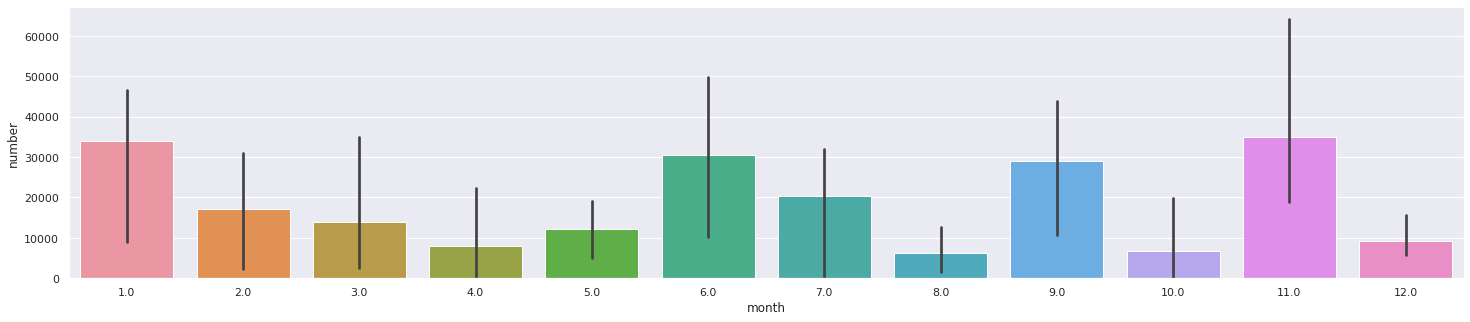

In [187]:
plt.rcParams['figure.figsize'] = [25, 5]
sns.barplot(monthly[(monthly.polygon_id==1)], x='month', y='number')
fig.autofmt_xdate()

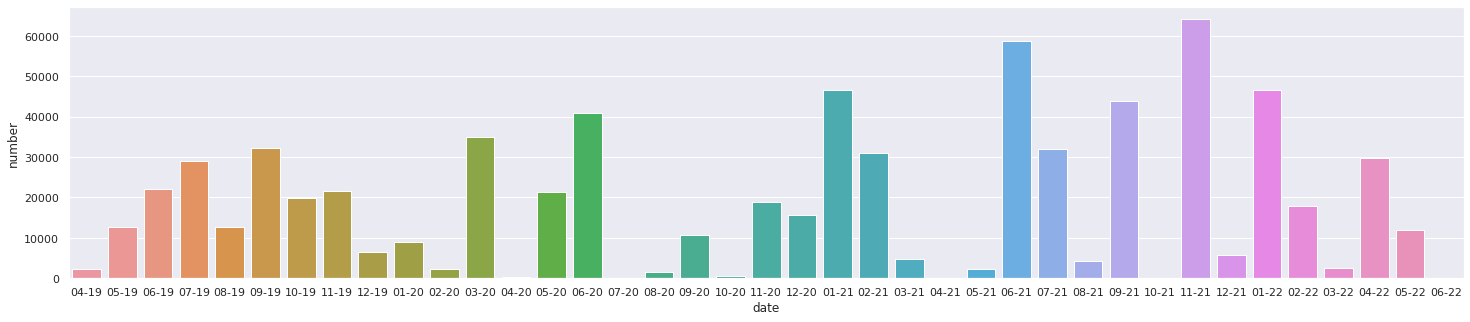

In [188]:
plt.rcParams['figure.figsize'] = [25, 5]
sns.barplot(monthly[(monthly.polygon_id==1)], x='date', y='number')
fig.autofmt_xdate()

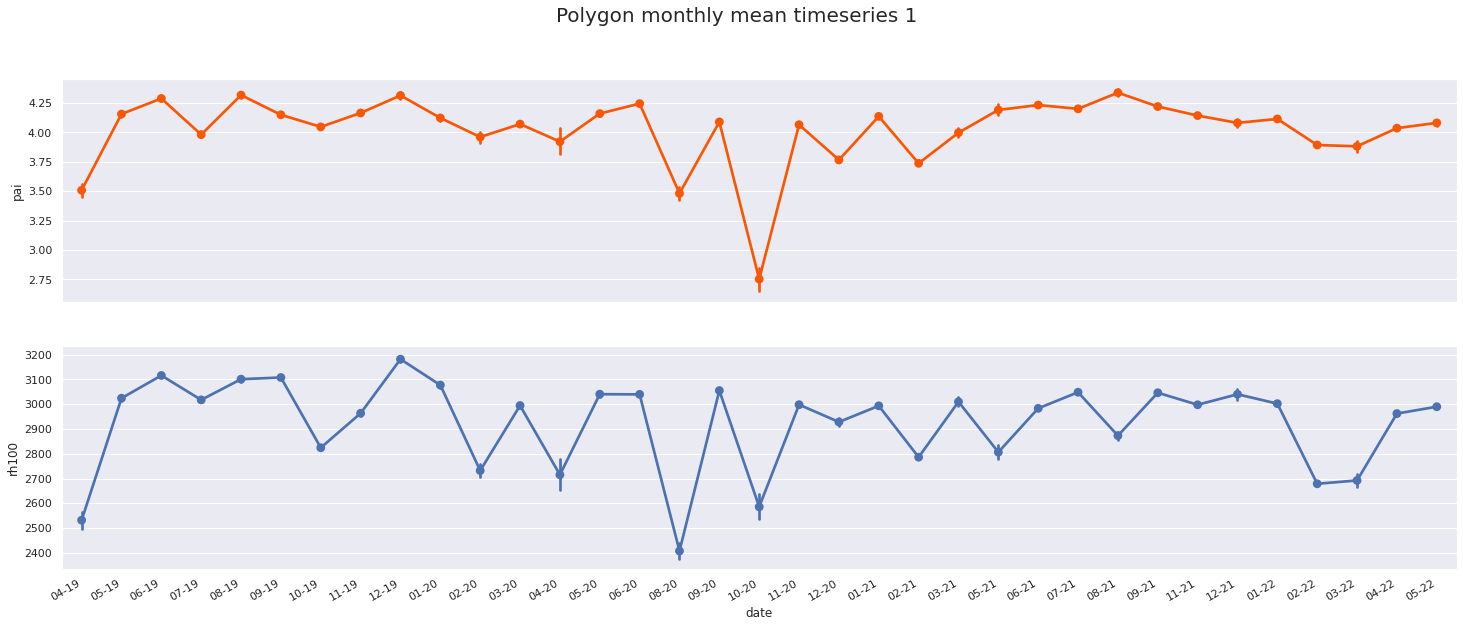

In [193]:
plot_monthly_time_series(footprints, 1)

1


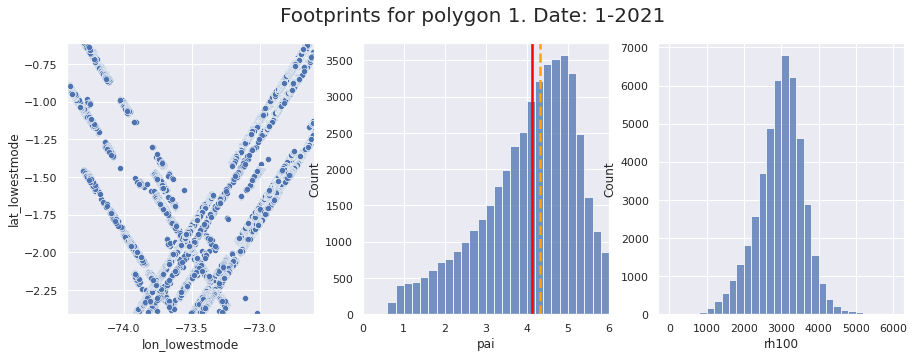

(46619, 15)
2


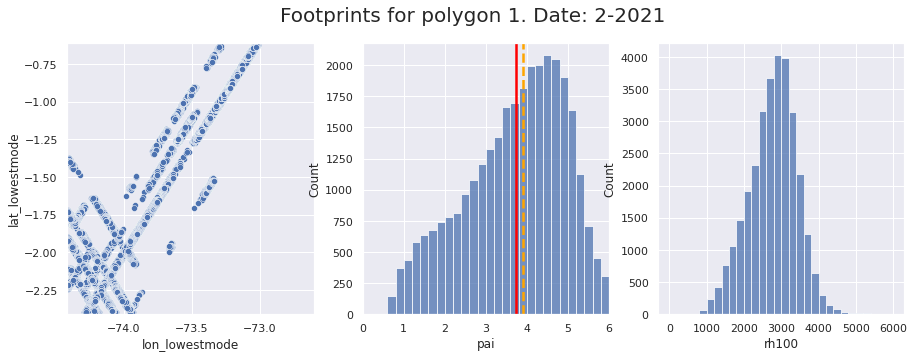

(31084, 15)
3


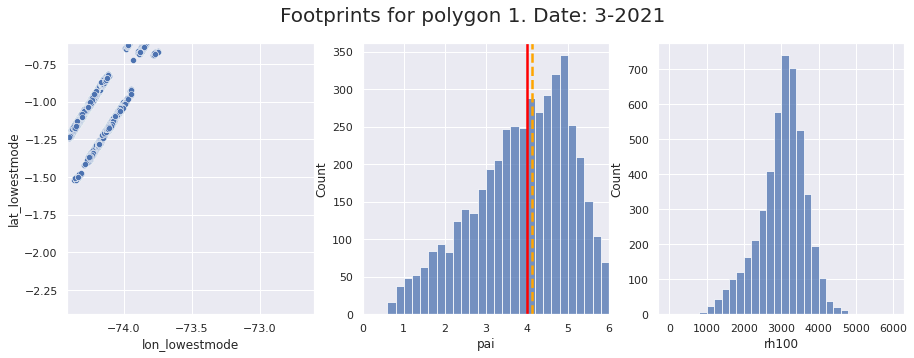

(4720, 15)
4


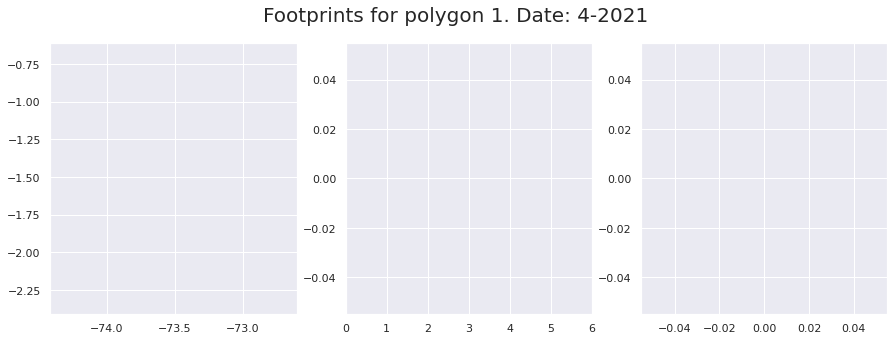

(0, 15)
5


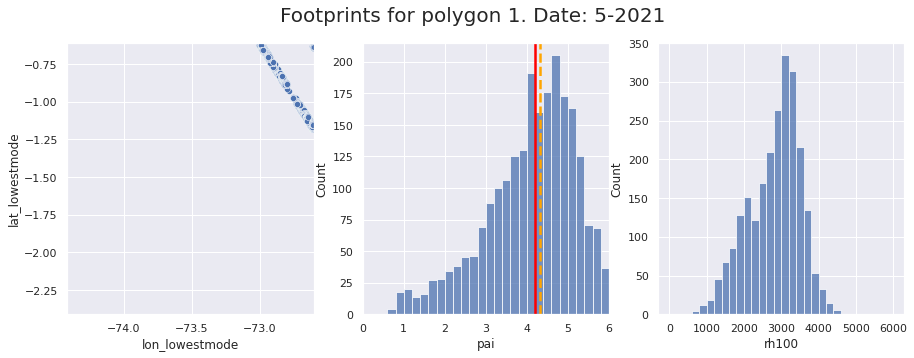

(2383, 15)
6


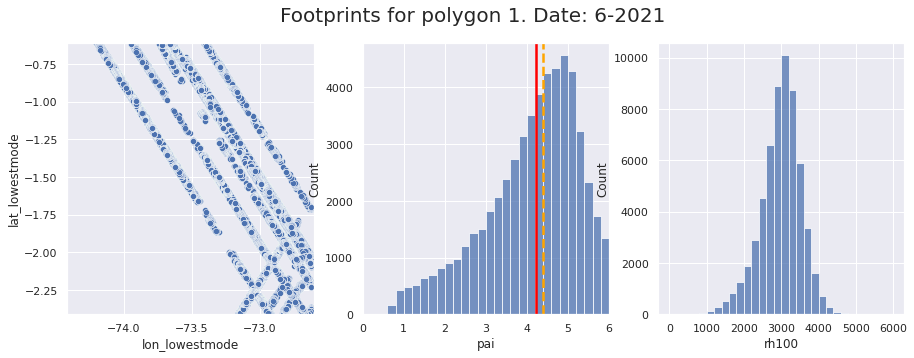

(58783, 15)
7


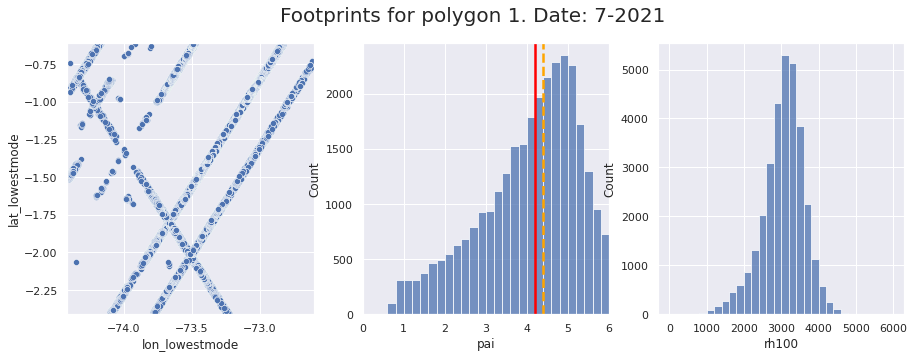

(31889, 15)
8


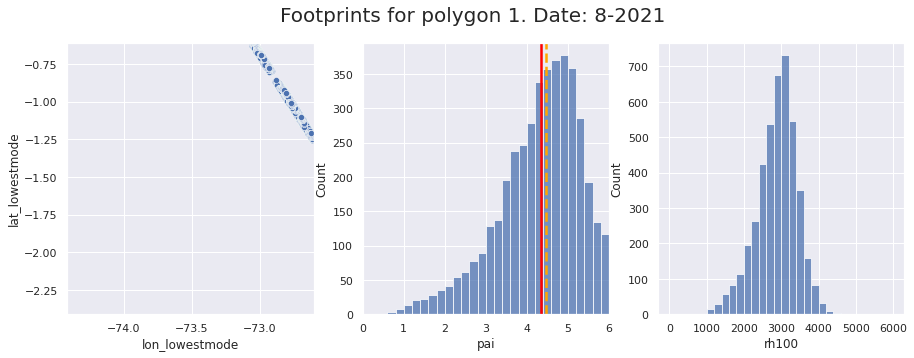

(4309, 15)
9


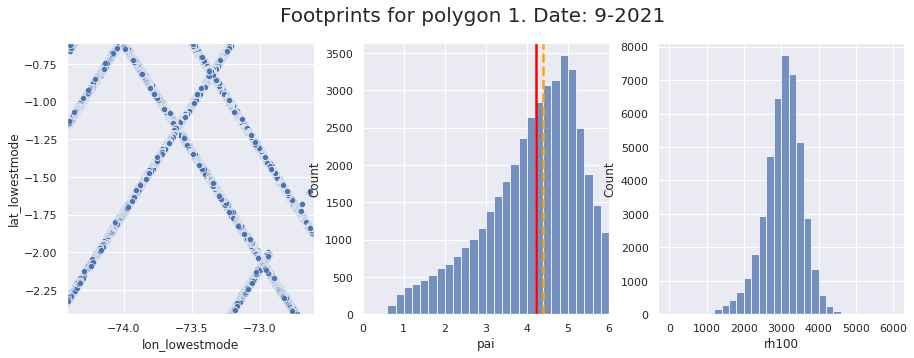

(43859, 15)
10


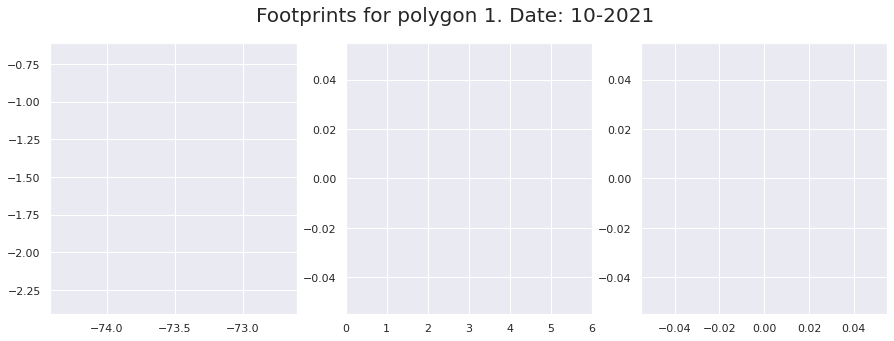

(0, 15)
11


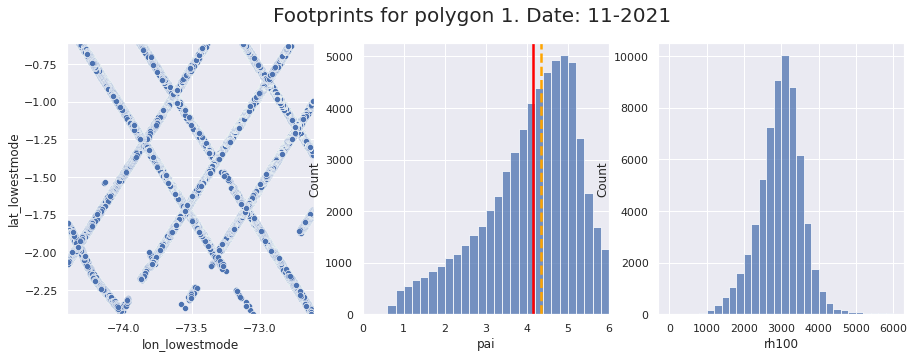

(64054, 15)
12


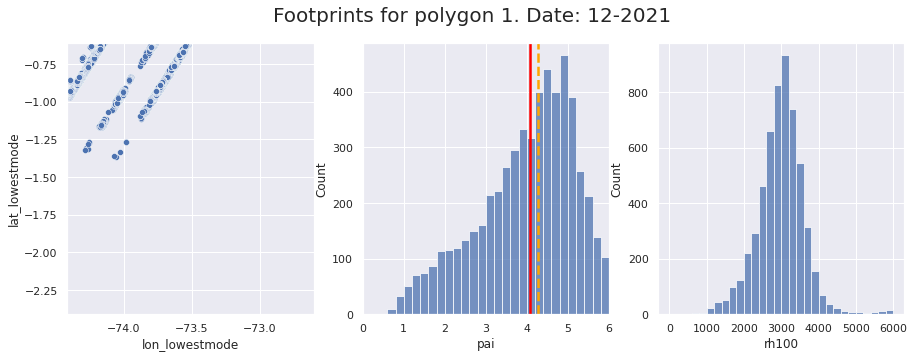

(5785, 15)


In [194]:
# Plot all months for a given year and a given polygon
year = 2021
for month in range(1, 13):
    print(month)
    print(plot_one_month_data(footprints, 1, month, year, pai_threshold=0.2).shape)

### Polygon 2

In [ ]:
plt.rcParams['figure.figsize'] = [25, 5]
sns.barplot(monthly[(monthly.polygon_id==2)], x='month', y='number')
fig.autofmt_xdate()

In [ ]:
plt.rcParams['figure.figsize'] = [25, 5]
sns.barplot(monthly[(monthly.polygon_id==2)], x='date', y='number')
fig.autofmt_xdate()

In [ ]:
plot_monthly_time_series(footprints, 2)

In [ ]:
# Plot all months for a given year and a given polygon
year = 2022
for month in range(1, 13):
    print(month)
    print(plot_one_month_data(footprints, 2, month, year, pai_threshold=0.2).shape)

### Polygon 3

In [ ]:
plt.rcParams['figure.figsize'] = [25, 5]
sns.barplot(monthly[(monthly.polygon_id==3)], x='month', y='number')
fig.autofmt_xdate()

In [ ]:
plt.rcParams['figure.figsize'] = [25, 5]
sns.barplot(monthly[(monthly.polygon_id==3)], x='date', y='number')
fig.autofmt_xdate()

In [ ]:
plot_monthly_time_series(footprints, 3)

In [ ]:
# Plot all months for a given year and a given polygon
year = 2022
for month in range(1, 13):
    print(month)
    print(plot_one_month_data(footprints, 3, month, year, pai_threshold=0.2).shape)

### Polygon 4

In [ ]:
plt.rcParams['figure.figsize'] = [25, 5]
sns.barplot(monthly[(monthly.polygon_id==4)], x='month', y='number')
fig.autofmt_xdate()

In [ ]:
plt.rcParams['figure.figsize'] = [25, 5]
sns.barplot(monthly[(monthly.polygon_id==4)], x='date', y='number')
fig.autofmt_xdate()

In [ ]:
plot_monthly_time_series(footprints, 4)

1


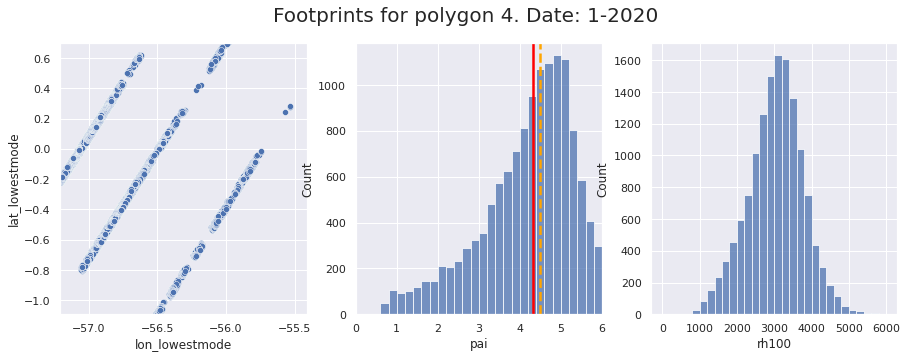

(13964, 15)
2


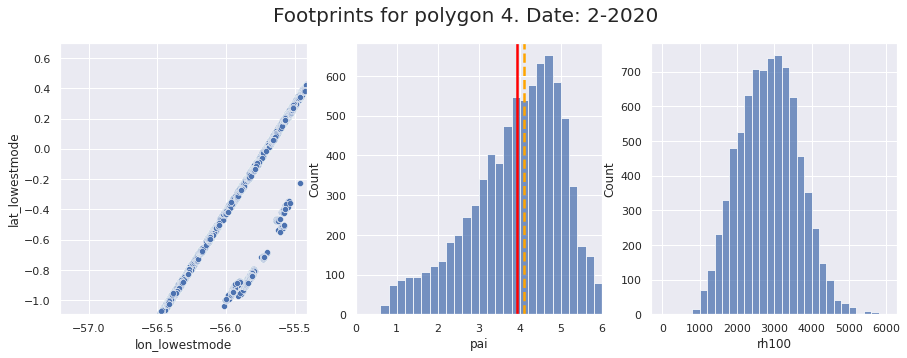

(8074, 15)
3


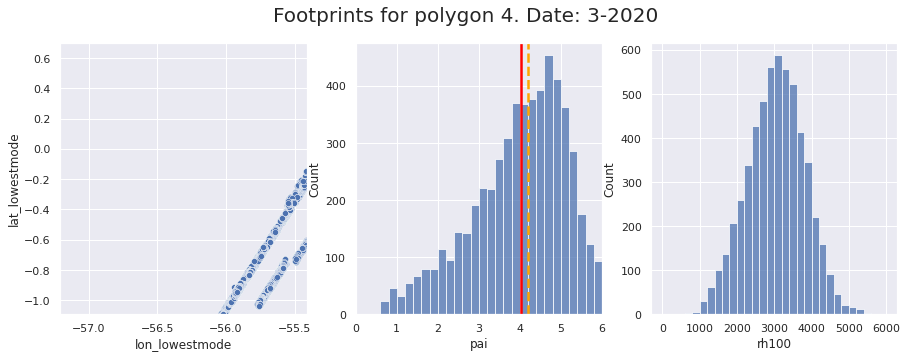

(5607, 15)
4


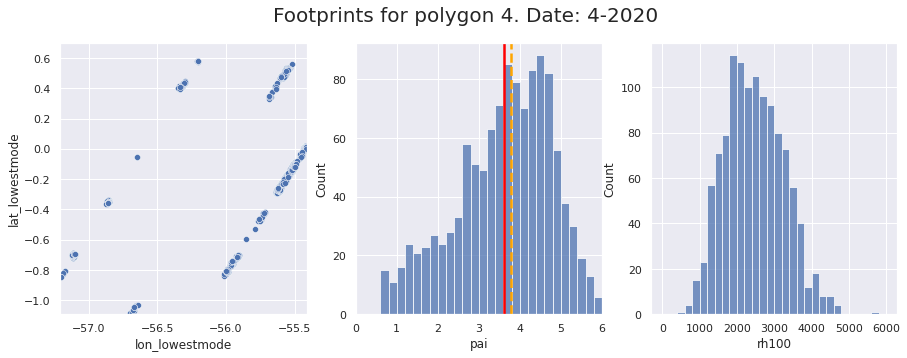

(1170, 15)
5


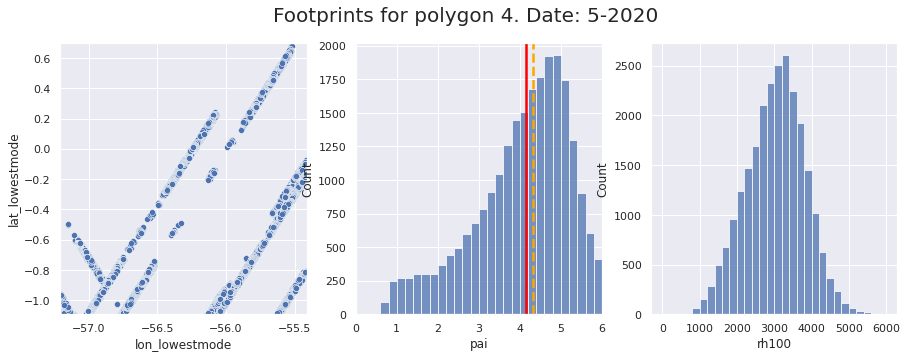

(24689, 15)
6


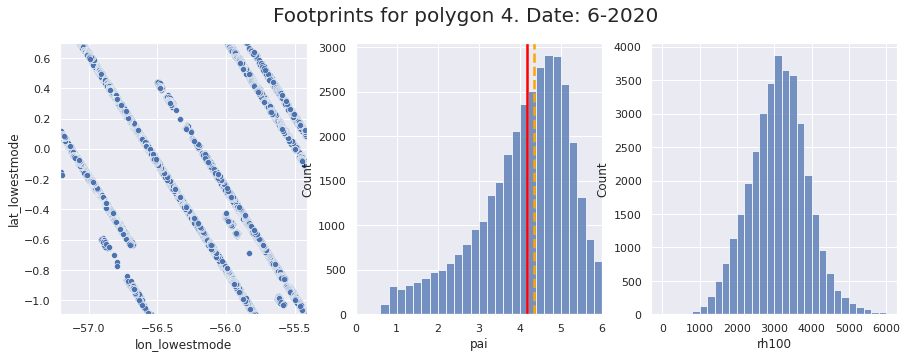

(35590, 15)
7


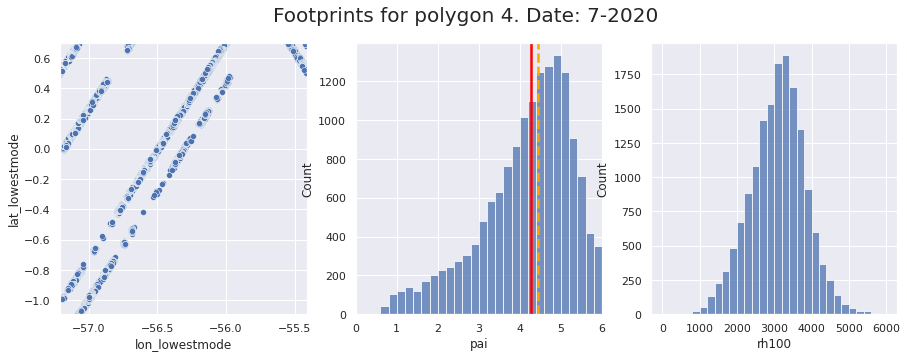

(16005, 15)
8


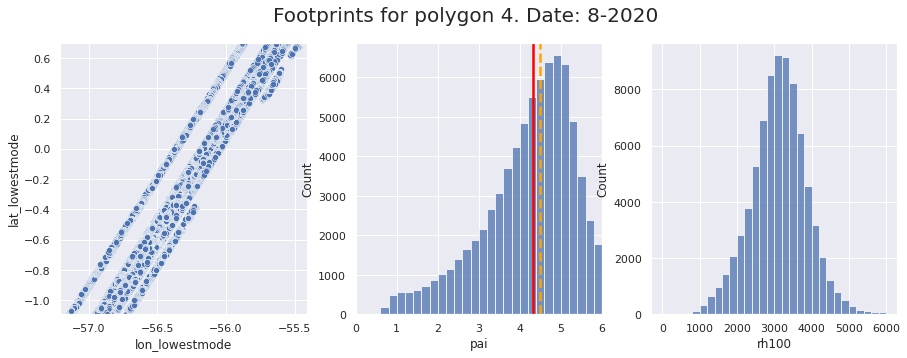

(79560, 15)
9


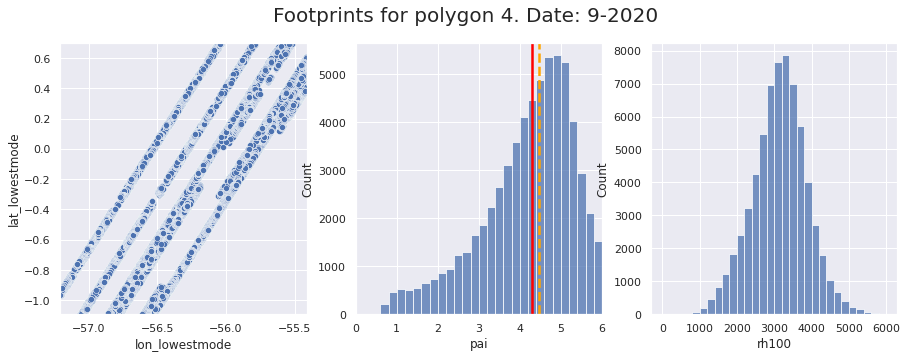

(66355, 15)
10


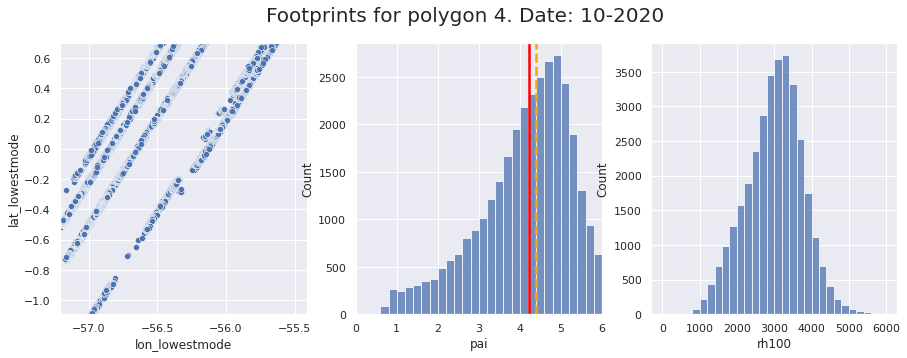

(33716, 15)
11


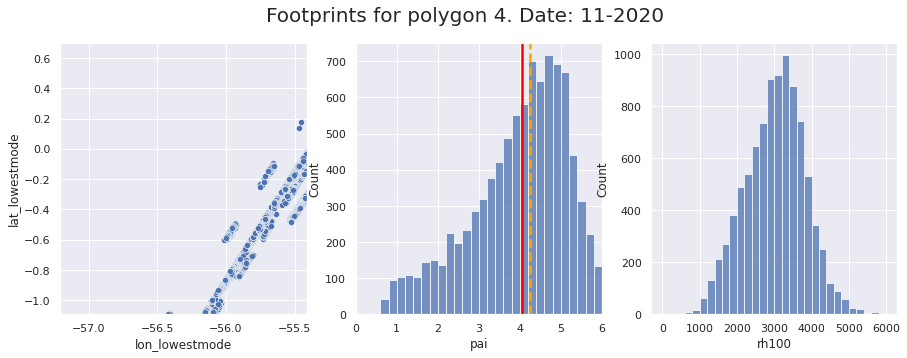

(9395, 15)
12


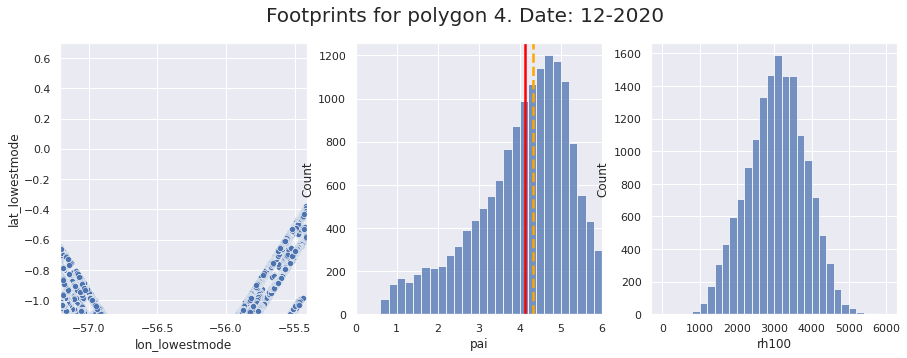

(15469, 15)


In [196]:
# Plot all months for a given year and a given polygon
year = 2020
for month in range(1, 13):
    print(month)
    print(plot_one_month_data(footprints, 4, month, year, pai_threshold=0.2).shape)

### Polygon 5

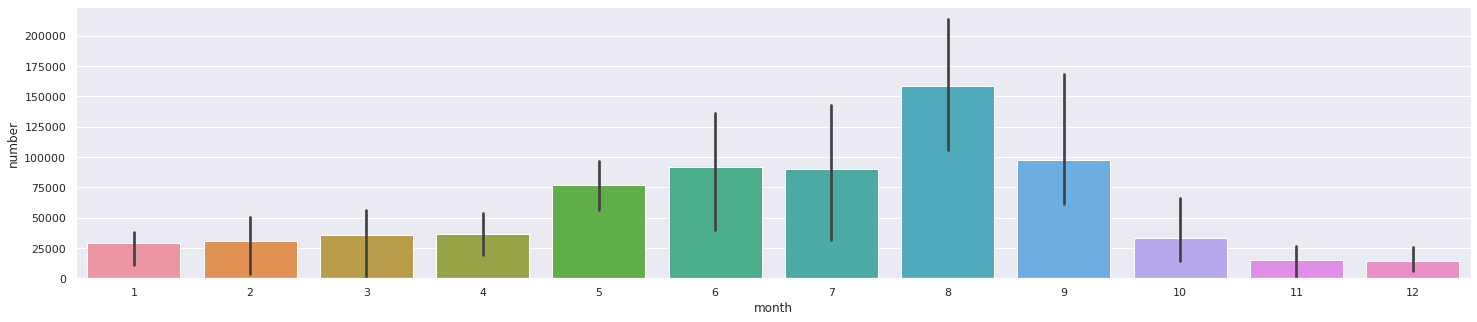

In [245]:
plt.rcParams['figure.figsize'] = [25, 5]
sns.barplot(monthly[(monthly.polygon_id==5)], x='month', y='number')
fig.autofmt_xdate()

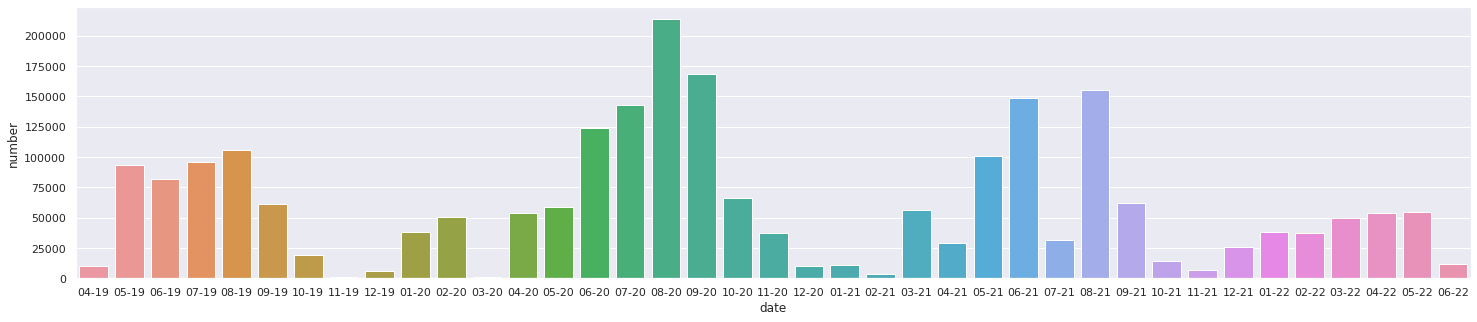

In [246]:
plt.rcParams['figure.figsize'] = [25, 5]
sns.barplot(monthly[(monthly.polygon_id==5)], x='date', y='number')
fig.autofmt_xdate()

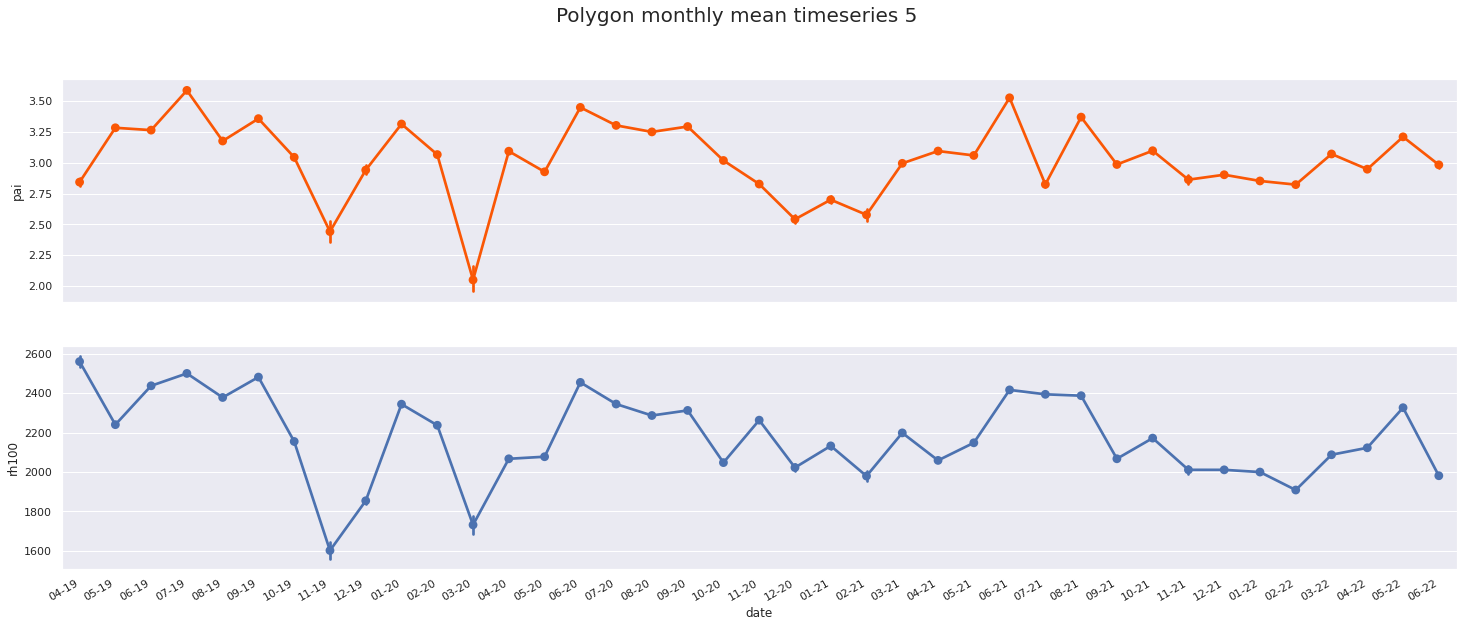

In [247]:
plot_monthly_time_series(footprints, 5)

1


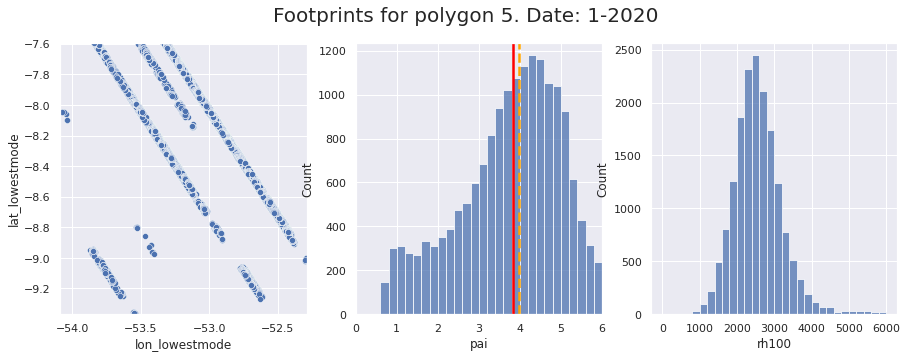

(17515, 15)
2


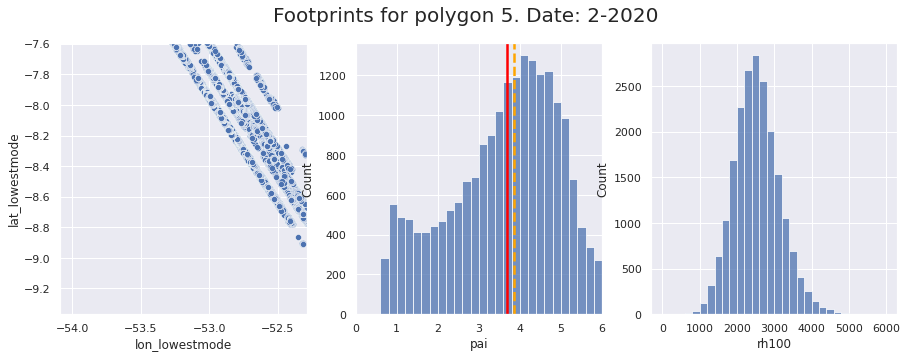

(20594, 15)
3


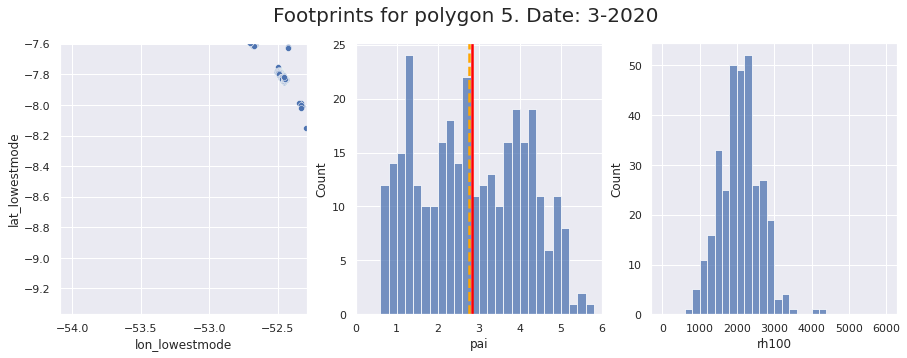

(324, 15)
4


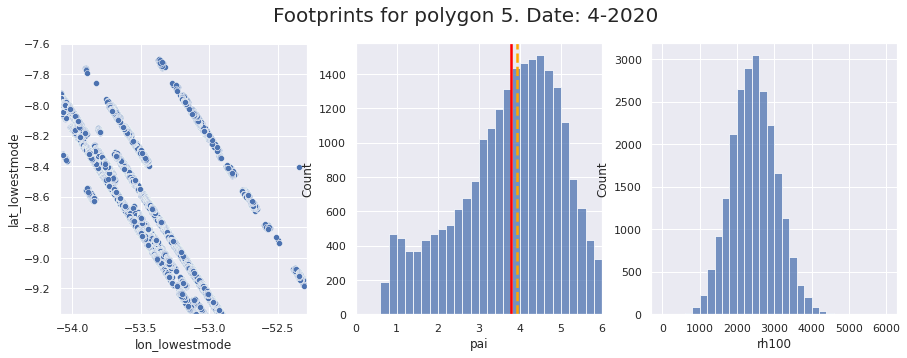

(22886, 15)
5


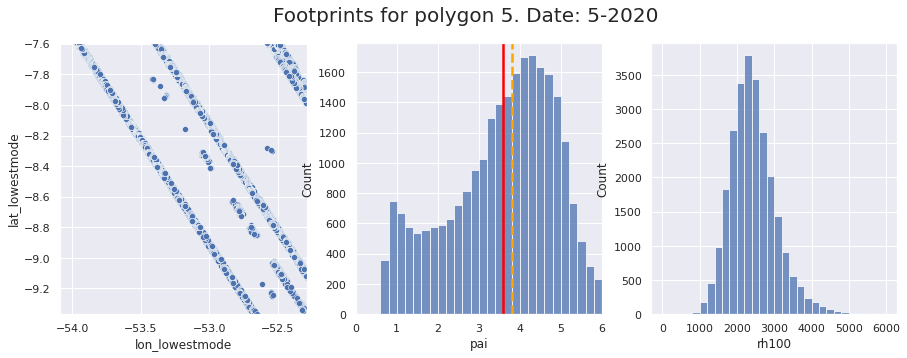

(25756, 15)
6


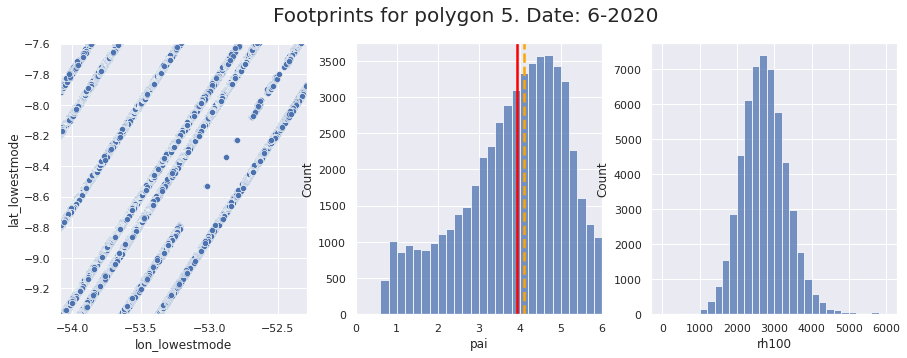

(55708, 15)
7


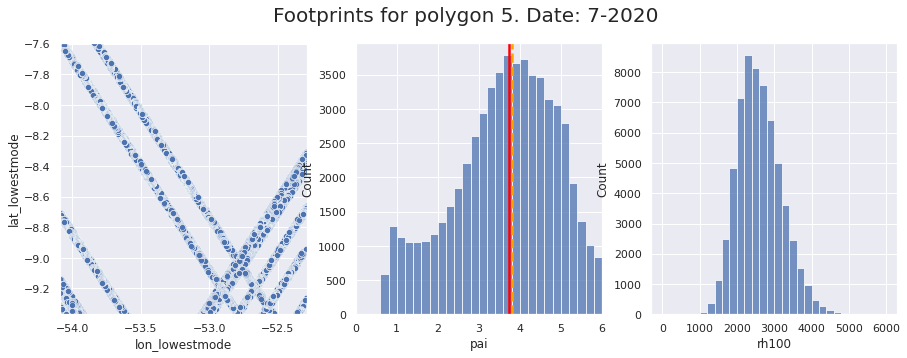

(61337, 15)
8


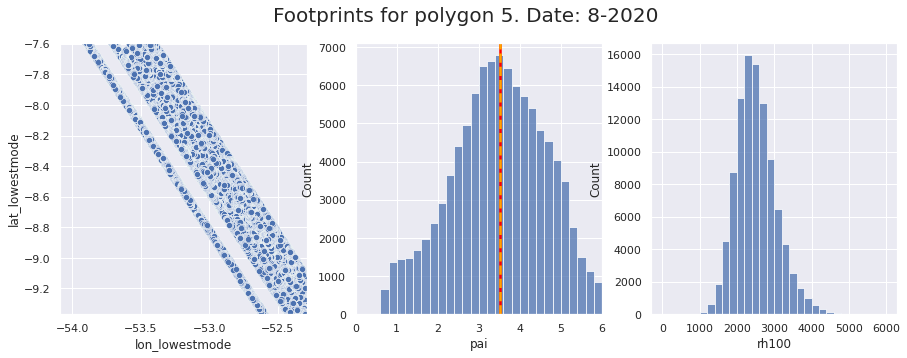

(100278, 15)
9


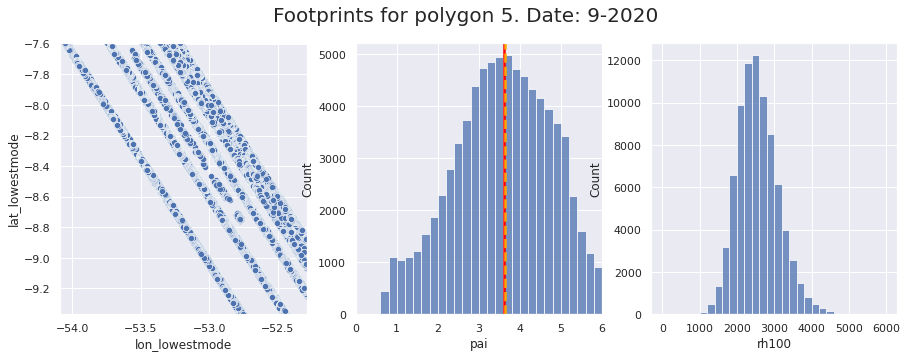

(80637, 15)
10


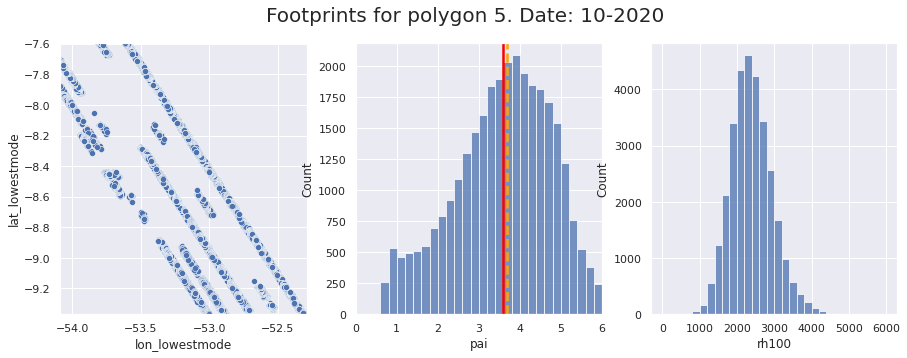

(30791, 15)
11


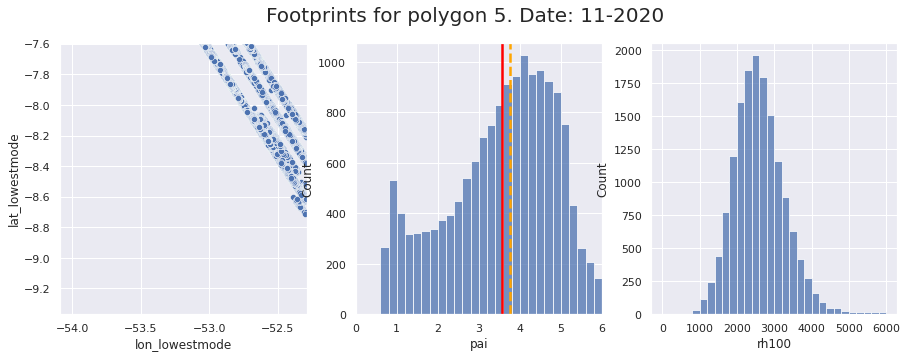

(15811, 15)
12


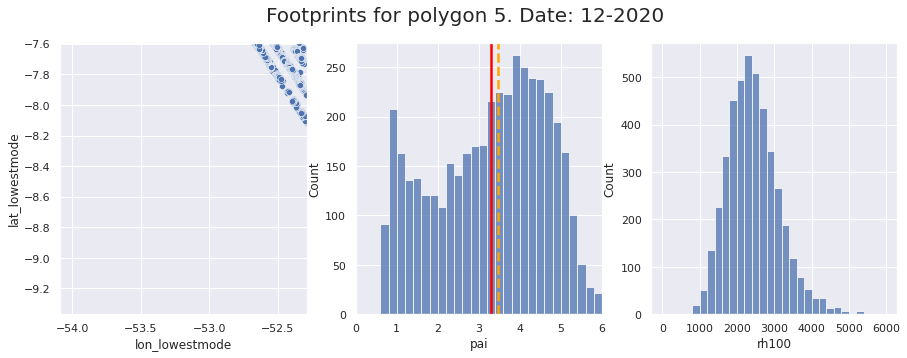

(4370, 15)


In [198]:
# Plot all months for a given year and a given polygon
year = 2020
for month in range(1, 13):
    print(month)
    print(plot_one_month_data(footprints, 5, month, year, pai_threshold=0.2).shape)